In [1]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib as mp
import matplotlib.animation as animation
import IPython


MASS = 0.600 # mass of the quadrotor
INERTIA = 0.15 # inertia of the quadrotor
        
LENGTH = 0.2 # length of the quadrotor
        
GRAVITY=9.81 #gravity constant

DELTA_T = 0.01 #integration step
        
NUMBER_STATES = 6 # number of states
NUMBER_CONTROLS = 2 # number of controls
        
            
def get_next_state(z,u):
    """
    Inputs:
    z: state of the quadrotor as a numpy array (x, vx, y, vy, theta, omega)
    u: control as a numpy array (u1, u2)

    Output:
    the new state of the quadrotor as a numpy array
    """
    x = z[0]
    vx = z[1]
    y = z[2]
    vy = z[3]
    theta = z[4]
    omega = z[5]

    dydt = np.zeros([NUMBER_STATES,])
    dydt[0] = vx
    dydt[1] = (-(u[0] + u[1]) * np.sin(theta)) / MASS
    dydt[2] = vy
    dydt[3] = ((u[0] + u[1]) * np.cos(theta) - MASS * GRAVITY) / MASS
    dydt[4] = omega
    dydt[5] = (LENGTH * (u[0] - u[1])) / INERTIA

    z_next = z + dydt * DELTA_T

    return z_next


    
def simulate(z0, controller, horizon_length, disturbance = False):
    """
    This function simulates the quadrotor for horizon_length steps from initial state z0

    Inputs:
    z0: the initial conditions of the quadrotor as a numpy array (x, vx, y, vy, theta, omega)
    controller: a function that takes a state z as argument and index i of the time step and returns a control u
    horizon_length: the horizon length

    disturbance: if True will generate a random push every seconds during the simulation

    Output:
    t[time_horizon+1] contains the simulation time
    z[4, time_horizon+1] and u[2, time_horizon] containing the time evolution of states and control
    """
    
    t = np.zeros([horizon_length+1,])
    z=np.empty([NUMBER_STATES, horizon_length+1])
    z[:,0] = z0
    u=np.zeros([NUMBER_CONTROLS, horizon_length])
    for i in range(horizon_length):
        u[:,i] = controller(z[:,i],i)
        z[:,i+1] = get_next_state(z[:,i], u[:,i])
        if disturbance and np.mod(i,100)==0:
            dist = np.zeros([NUMBER_STATES, ])
            dist[1::2] = np.random.uniform(-1.,1,(3,))
            z[:,i+1] += dist
        t[i+1] = t[i] + DELTA_T
    return t, z, u
    
    
def animate_robot(x, u, dt = 0.01):
    """
    This function makes an animation showing the behavior of the quadrotor
    takes as input the result of a simulation (with dt=0.01s)
    """

    min_dt = 0.1
    if(dt < min_dt):
        steps = int(min_dt/dt)
        use_dt = int(np.round(min_dt * 1000))
    else:
        steps = 1
        use_dt = int(np.round(dt * 1000))

    #what we need to plot
    plotx = x[:,::steps]
    plotx = plotx[:,:-1]
    plotu = u[:,::steps]

    fig = mp.figure.Figure(figsize=[8.5,8.5])
    mp.backends.backend_agg.FigureCanvasAgg(fig)
    ax = fig.add_subplot(111, autoscale_on=False, xlim=[-4,4], ylim=[-4,4])
    ax.grid()

    list_of_lines = []

    #create the robot
    # the main frame
    line, = ax.plot([], [], 'k', lw=6)
    list_of_lines.append(line)
    # the left propeller
    line, = ax.plot([], [], 'b', lw=4)
    list_of_lines.append(line)
    # the right propeller
    line, = ax.plot([], [], 'b', lw=4)
    list_of_lines.append(line)
    # the left thrust
    line, = ax.plot([], [], 'r', lw=1)
    list_of_lines.append(line)
    # the right thrust
    line, = ax.plot([], [], 'r', lw=1)
    list_of_lines.append(line)

    def _animate(i):
        for l in list_of_lines: #reset all lines
            l.set_data([],[])

        theta = plotx[4,i]
        x = plotx[0,i]
        y = plotx[2,i]
        trans = np.array([[x,x],[y,y]])
        rot = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

        main_frame = np.array([[-LENGTH, LENGTH], [0,0]])
        main_frame = rot @ main_frame + trans 

        left_propeller = np.array([[-1.3 * LENGTH, -0.7*LENGTH], [0.1,0.1]])
        left_propeller = rot @ left_propeller + trans

        right_propeller = np.array([[1.3 * LENGTH, 0.7*LENGTH], [0.1,0.1]])
        right_propeller = rot @ right_propeller + trans

        left_thrust = np.array([[LENGTH, LENGTH], [0.1, 0.1+plotu[0,i]*0.04]])
        left_thrust = rot @ left_thrust + trans

        right_thrust = np.array([[-LENGTH, -LENGTH], [0.1, 0.1+plotu[0,i]*0.04]])
        right_thrust = rot @ right_thrust + trans

        list_of_lines[0].set_data(main_frame[0,:], main_frame[1,:])
        list_of_lines[1].set_data(left_propeller[0,:], left_propeller[1,:])
        list_of_lines[2].set_data(right_propeller[0,:], right_propeller[1,:])
        list_of_lines[3].set_data(left_thrust[0,:], left_thrust[1,:])
        list_of_lines[4].set_data(right_thrust[0,:], right_thrust[1,:])

        return list_of_lines

    def _init():
        return _animate(0)


    ani = animation.FuncAnimation(fig, _animate, np.arange(0, len(plotx[0,:])),
        interval=use_dt, blit=True, init_func=_init)
    plt.close(fig)
    plt.close(ani._fig)
    IPython.display.display_html(IPython.core.display.HTML(ani.to_html5_video()))

In [2]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt

import quadrotor

In [3]:
# we can get its mass, half length (r), gravity constant
print(f'm is {quadrotor.MASS}')
print(f'r is {quadrotor.LENGTH}')
print(f'I is {quadrotor.INERTIA}')
print(f'g is {quadrotor.GRAVITY}')

# we can also get the integration step used in the simulation
print(f'dt is {quadrotor.DELTA_T}')

# we can get the size of its state and control vector
print(f'number of states {quadrotor.NUMBER_STATES} and number of controls {quadrotor.NUMBER_CONTROLS}')
print('the states are indexed as follows: x, vx, y, vy, theta, omega')

m is 0.6
r is 0.2
I is 0.15
g is 9.81
dt is 0.01
number of states 6 and number of controls 2
the states are indexed as follows: x, vx, y, vy, theta, omega


# PART 1

In [4]:
# we can simulate the robot but we need to provide a controller of the following form
def dummy_controller(state, i):
    """
        the prototype of a controller is as follows
        state is a column vector containing the state of the robot
        i is the index corresponding to the time step in the horizon (useful to index gains K for e.g.)
        
        this controller needs to return an array of size (2,)
    """
    # here we do nothing and just return some non-zero control
    return quadrotor.MASS*quadrotor.GRAVITY/2. * np.ones([2,])




# we can now simulate for a given number of time steps - here we do 10 seconds
horizon_length = 1000
z0 = np.zeros([quadrotor.NUMBER_STATES,])
# z0[0] = 1
t, state, u = quadrotor.simulate(z0, dummy_controller, horizon_length, disturbance = False)

<IPython.core.display.Javascript object>


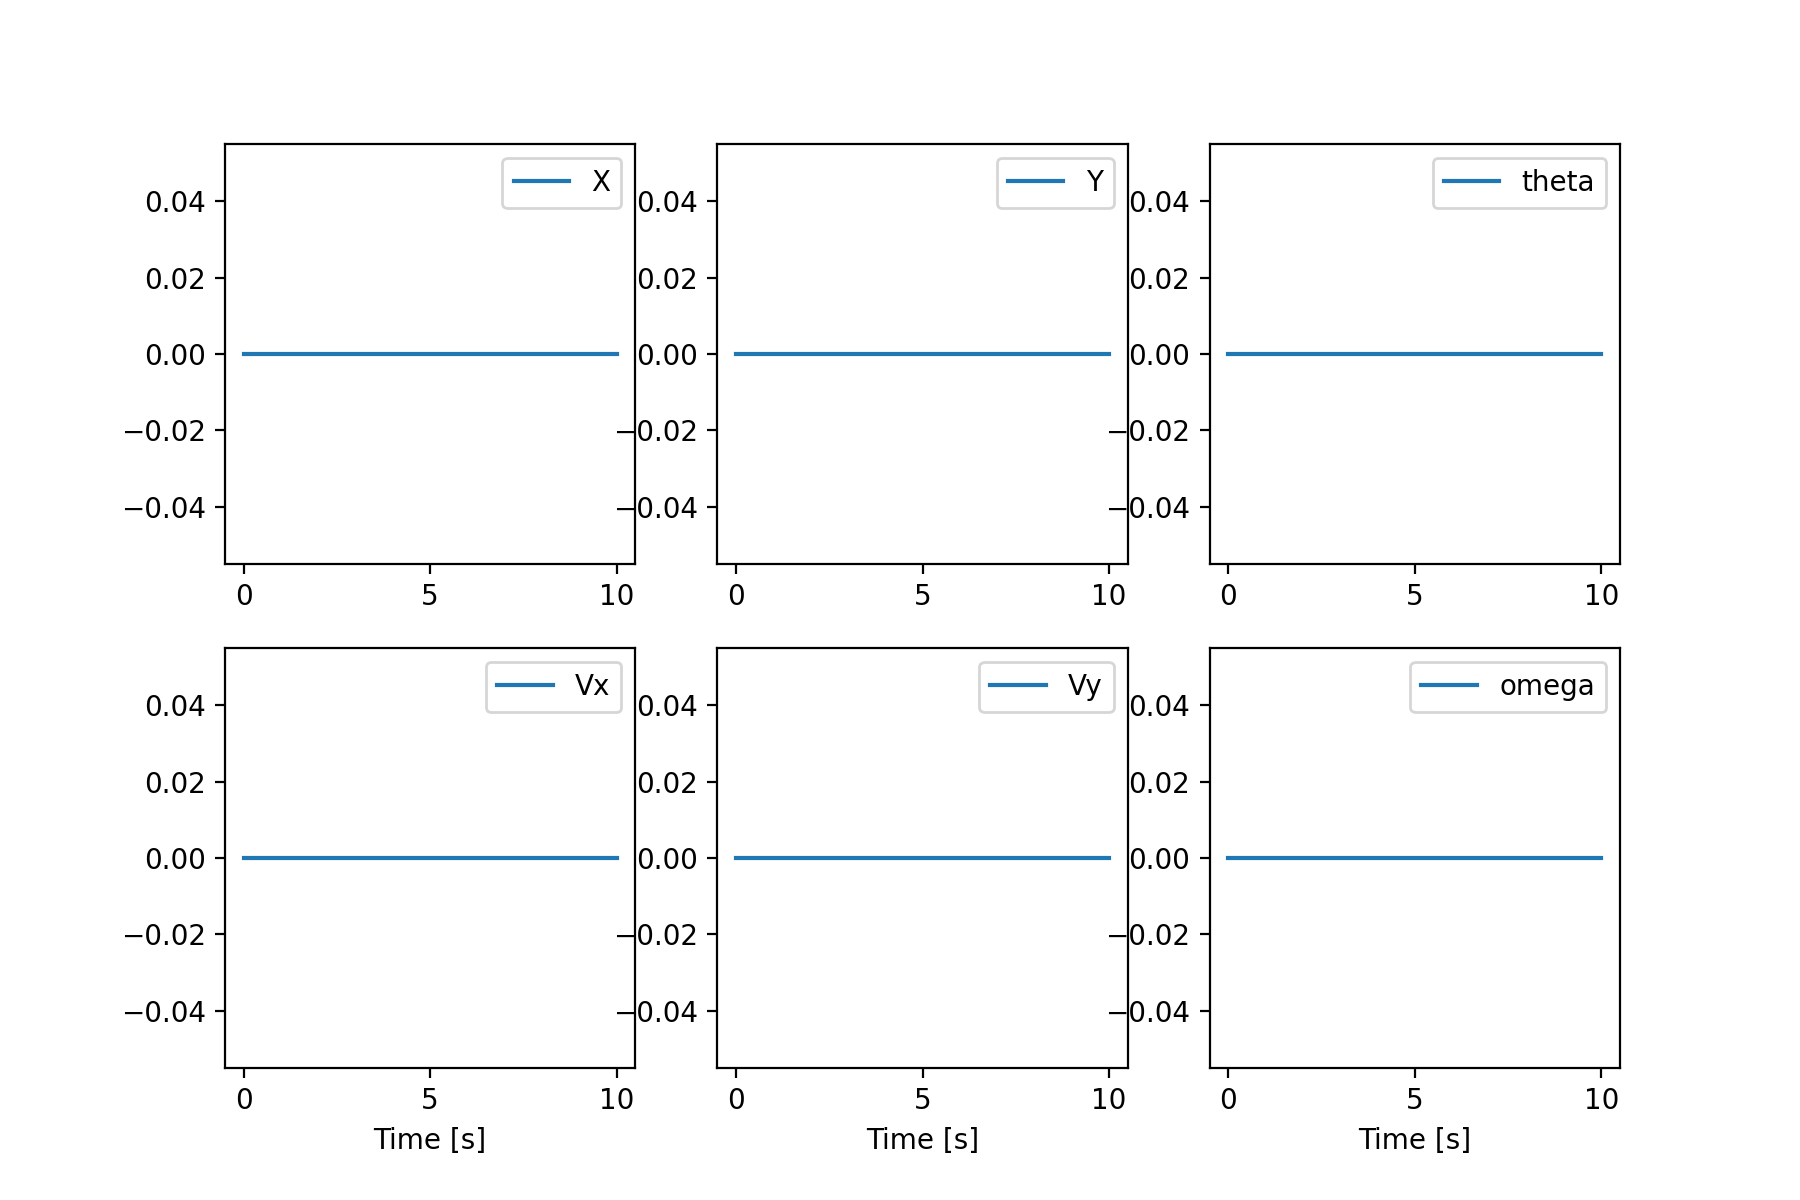

<IPython.core.display.Javascript object>


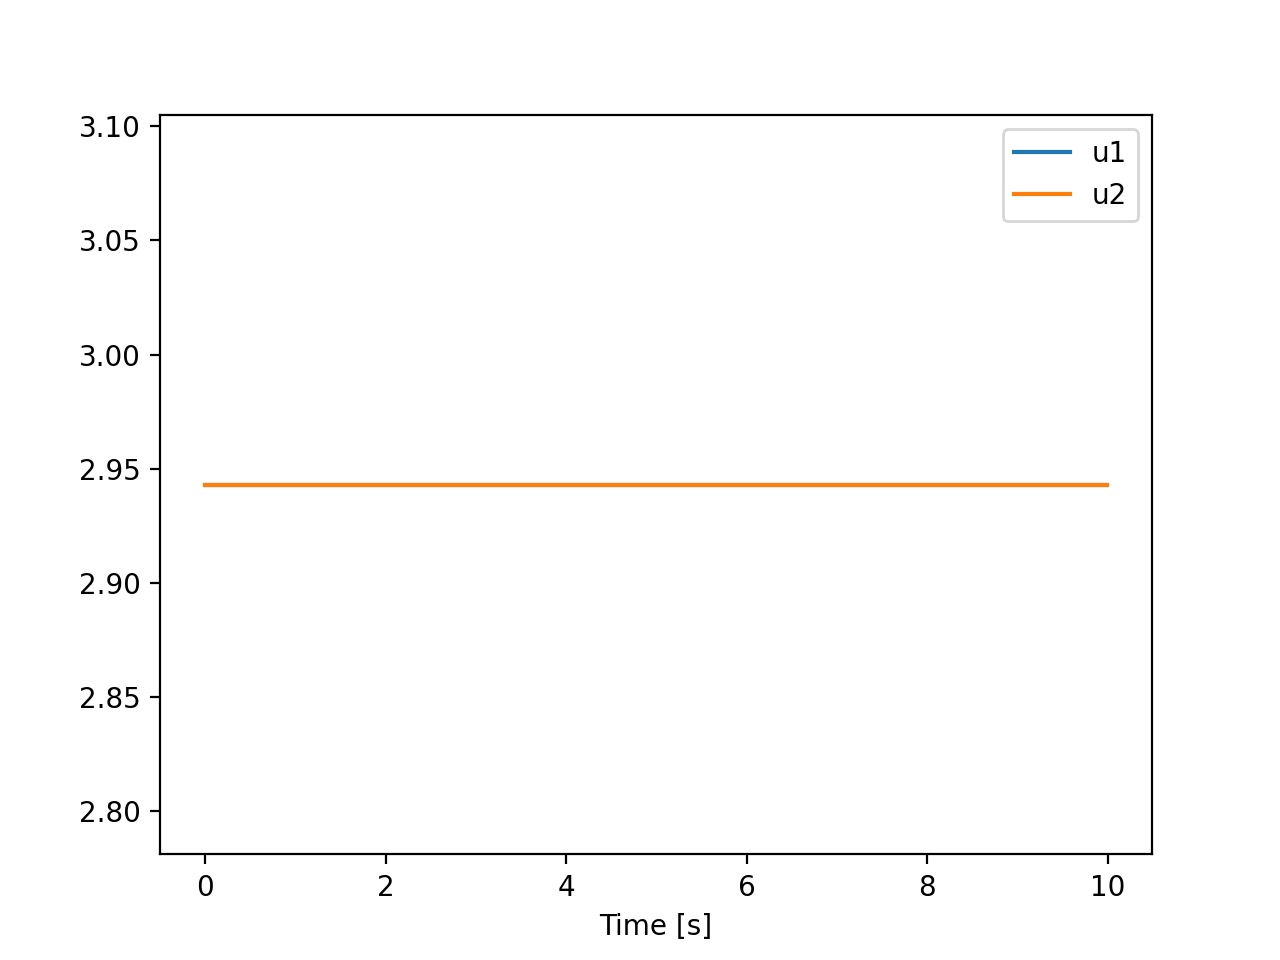

Text(0.5, 0, 'Time [s]')

In [5]:
# we can plot the results
plt.figure(figsize=[9,6])

plt.subplot(2,3,1)
plt.plot(t, state[0,:])
plt.legend(['X'])

plt.subplot(2,3,2)
plt.plot(t, state[2,:])
plt.legend(['Y'])

plt.subplot(2,3,3)
plt.plot(t, state[4,:])
plt.legend(["theta"])

plt.subplot(2,3,4)
plt.plot(t, state[1,:])
plt.legend(['Vx'])
plt.xlabel('Time [s]')

plt.subplot(2,3,5)
plt.plot(t, state[3,:])
plt.legend(['Vy'])
plt.xlabel('Time [s]')

plt.subplot(2,3,6)
plt.plot(t, state[5,:])
plt.legend(['omega'])
plt.xlabel('Time [s]')

# we can also plot the control
plt.figure()
plt.plot(t[:-1], u.T)
plt.legend(['u1', 'u2'])
plt.xlabel('Time [s]')

In [6]:
# now we can also create an animation
quadrotor.animate_robot(state, u)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAJSltZGF0AAACsAYF//+s
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MSByMzAzME0gOGJkNmQyOCAtIEguMjY0L01Q
RUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMjAgLSBodHRwOi8vd3d3LnZpZGVvbGFu
Lm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5h
bHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhl
ZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAg
ZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0x
NSBsb29rYWhlYWRfdGhyZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGlu
dGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMg
Yl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dv
cD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFf
cmVmcmVzaD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9
MC42MCBxcG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAA
ABL/ZYiEABH//veIHzLLafk613IR560urR9Q7kZxXqS9/iAAAAMAAAMAAAMACpJYniKH8XjN/AAA
AwAAt4AXsAwgCqgMKj6IdndnTzAIiR6+OnDbVkTjpPexGHLjoXY30hkXEhSE9kEKIJNbrApCI4G7
3ihHZi4T1K1iog5Wc0p6pLHThCwCmnYhSqYpYbTo2n5tZjl9Sersc3rmxTCU1aG5ejWlf2ZiBPtJ
6vuZEf6FCWPekrjf3iOxg9nYeAC3//ekaJ6Uup8pEnX74AtF5miPCXmGYp1VgIlMhblKE1f5XLlx
b1HUXmuG+fEgDCAJNggrSWMoFVS8OFpaDDMvSO64pmzh6vHDoKtfmcA4i12uUsh7rwNZe/BI7Ldb
aaCmFlaKG6p3WlZZBOgLc6Xh6KGqBk+DXTIvzmnGdaE/vYVZrpQqE5tWlH1wLzpsCVXhaMhwyKlI
HYXCzI57hN1GXk5AJs78kL3L0uFeE8COidDOFd4yzkoe/7l2h6wEKOz7uFgABdAAABgT/XL0eR8k
6J3lRIGcTlhh/LgQemvB9LeOOPbS/io9bEKpktMzUsr2rH7n7gn+AW5ayX7+OPXTsJWi5Af6cl+Q
nz0uW+DYBLS5p2thXpovCDk56tcwW0pgAmn5ff2hXXmI9LQE3pWGz9avZjnRjG4VNxvRD6MJBuoG
FZz0TZh4HejXX+Xr6AY1NtLhG5Dt0FFT7heDy2T/J56stCiLolYaEC4p05K0aorPFraz5ghGQBtP
bQZ5VBg8qxe+N9V/RoLK6+L+jsR9zqc/FKb+oyB4yMz+VqiGSA1AmSU7UJevM24L7eydq2v28GaT
OqWqMHCbTOWTxNuM9/axfRKDwC6Lso0wVC+3Ha0a7n9mpkc3W+Un55ci6TSbFMjFF3b1MWURykWb
CJ85PQh3+ppoRc3jGvBnmJGliXBKoNsDuPI5TzRngiKSJI++xRIAAAMAAAMAAAMAAAp0VA2a/arW
LxPwoBHTwZ0oXGqFZW746x5wHSckPf4eGNjDSS4E3h/9rm7GnwEJr/3+H8YrlaDOTR5xwjgOeIlw
h5Bdt6gdkU//ZrSiz8A8sRK4Ip3pzqQJmuxrBusupZOnBCCgB1GAtXRTnnmF/zozv4e91k/MQ76E
ImzqTIb21n9P9d7r4Tj4ctkcb3QLJoQ9oZLeP/mZgeDcwDgNGGa88S6KwuA1lJYLVhWkAKgpca+p
QyPAmzdqxvVmqA+n9+OAkZ+V8w3hsJXiyDlJzJQRftHHD/UZKmOov2gOVYG65nsP/pBy7ZThxPON
jqtapHzZ1I6Z/ntfJQnRK/UMqZA7MWBpwF2yAbQ8OXRgICKj/J+zwq9DQs5aprG52N8+wdyZw6Op
Knot6APk5kCQAAbt3cswf98VQgESJkJJAA+SWSIQAb8pg7QEFCLe6x9Zzxyi5C24b05PSE+hR+Eg
gohmIxcZh0elgKDRY8mlCqHcbxEm594ROE2dJzfl2Dqpd2M+MS5ruFrOWGZNN1bVHlmfbBTpfHg9
W2UxJ+a2R3nDDaIZZIrxwAE1nU8Nw6JRlC4/4Zod+2K6jCJjbBlLYpkFsk3og8YD4K250VTSb3dT
SzhD9I2ZBnmcm00cowt9f/YLxyZtDPHk7Hplbz09W3c+Wzd8AyXyAfK/ZSRHtc8hqRajX5giHsLK
evZSXOYXdpOzWaMmTFJ3AaJkGj6/dodcx2nao8FRdfe27LH3IMby3xZwLnHGnwfbRog6xjQwXCu8
rQNxGRx9dKQ5epjb8f3bT9qeHCvQFW/yoepy+ZFgfMHra/m/r/JCMWGesdYqDFb4linLAoBmVMVe
J938Xv+O6AhFeZwSttRhOkl6NWO0QY6Q3aKC0xc66DVHttxVC/vwbj7o4TjZYCSnLTh/xKNsVqyn
B+74OAAA6xzUR2r8eQAAElb7OqBM2GgBYq+Q2qk+jokBZBr6u/eplTAEyG16unWO8fJp8buBAu6l
9EJkB4NyhM0gbhzd5irjrq+L0T4itgdj/dNhd60D9RzqgjoUkNGJBj4f9nWmbCCypjajPzWo8qeG
+rH0qlbyGq77+9ZAcoFAkY8Uas8eiWzyLk83+wVHHN0CSK3dkzsBRSkUU7MHfQsKsRXxKHSg9iE+
WSS8oyLQGTxHvDvh2sBcQ/VMVFZrUi9i5XyjmVVGPFCxaCo82VhhW/viP6y9/aGibXv6BRoXiAV9
yPZgqpNgIqKv4yzdonjMAv4863F/n+keTnQV1mg0UnD7AZzlVivh50AXI+ZOhiEyaSGCijnPPIBU
5HZDTJVpkR95r3pnra1t26XYracD8/zpz9uYpOfXkXmTpk/sAzPv4w33lQqm+mJrUDHD8erR0nRB
denrY1HP9DWAFlpga8fjprwlXukfxGVgXKiZiwu3fZq9pJjHOo1ZtEpDRJpri9h6wGjuyXsefkWD
79ZCJnJ3LGfaEoVKGwehdRDzIqW71Oqx7wVvQVAht0S1mGGVgy9ukpU2cM1vKx/ZjQTGOds+Z6FN
gDZHeVbEAiQwh1ns1rM+Y+ZN+ed3DxMgIzVmoHaI/3sJ7rhgLRTO9N9uazDK3Ckc1hrrRFU/QUbM
uDcxlOwAQAQZlSvb0FvE5ROYakY6cLmq3X/OhAgI2cnPRtpQfNPI3fOXdUgcuErXHybW6iSuDm0I
KuOa2PtrKUHF5E6G8+PxVgD7TV706ltC/m8hDLlaA96b6V1uxQRlX6UtyHiJVrfzaDNWAARQfArL
8dxhdEz30tkvfWDU8Ljz/4tZpGe972r9KUOQAqtIX90Sy4DPFFGuwjNwTN6CfE+jDRWPbAYHdxdq
zUD+6vaoDy5PKdjW8ZkgxPPsfrzWHCgtNoiAfJb/92la1D0U2DXnMfDVEimdpVGlGFEW2S8HelDT
gynT5cwpaF6hei0H+b75J

<IPython.core.display.Javascript object>


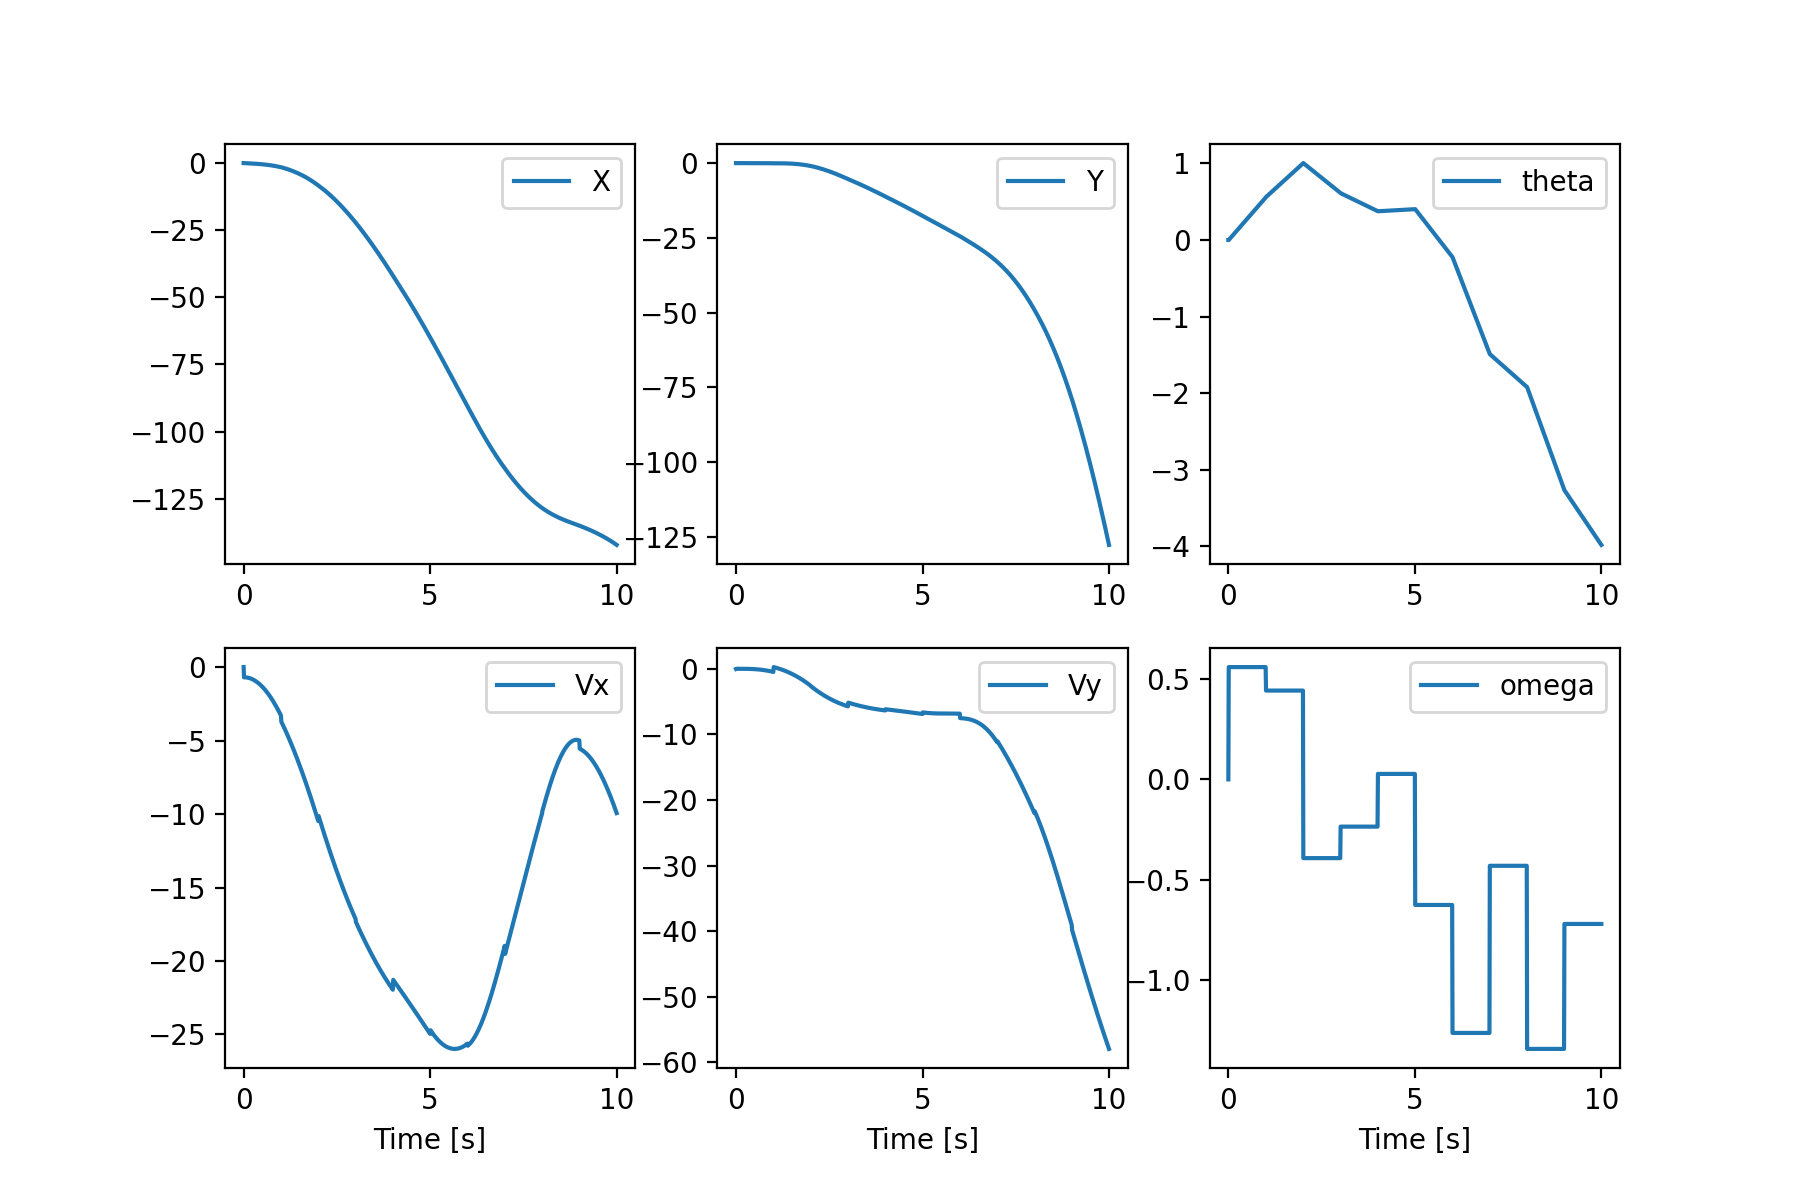

<IPython.core.display.Javascript object>


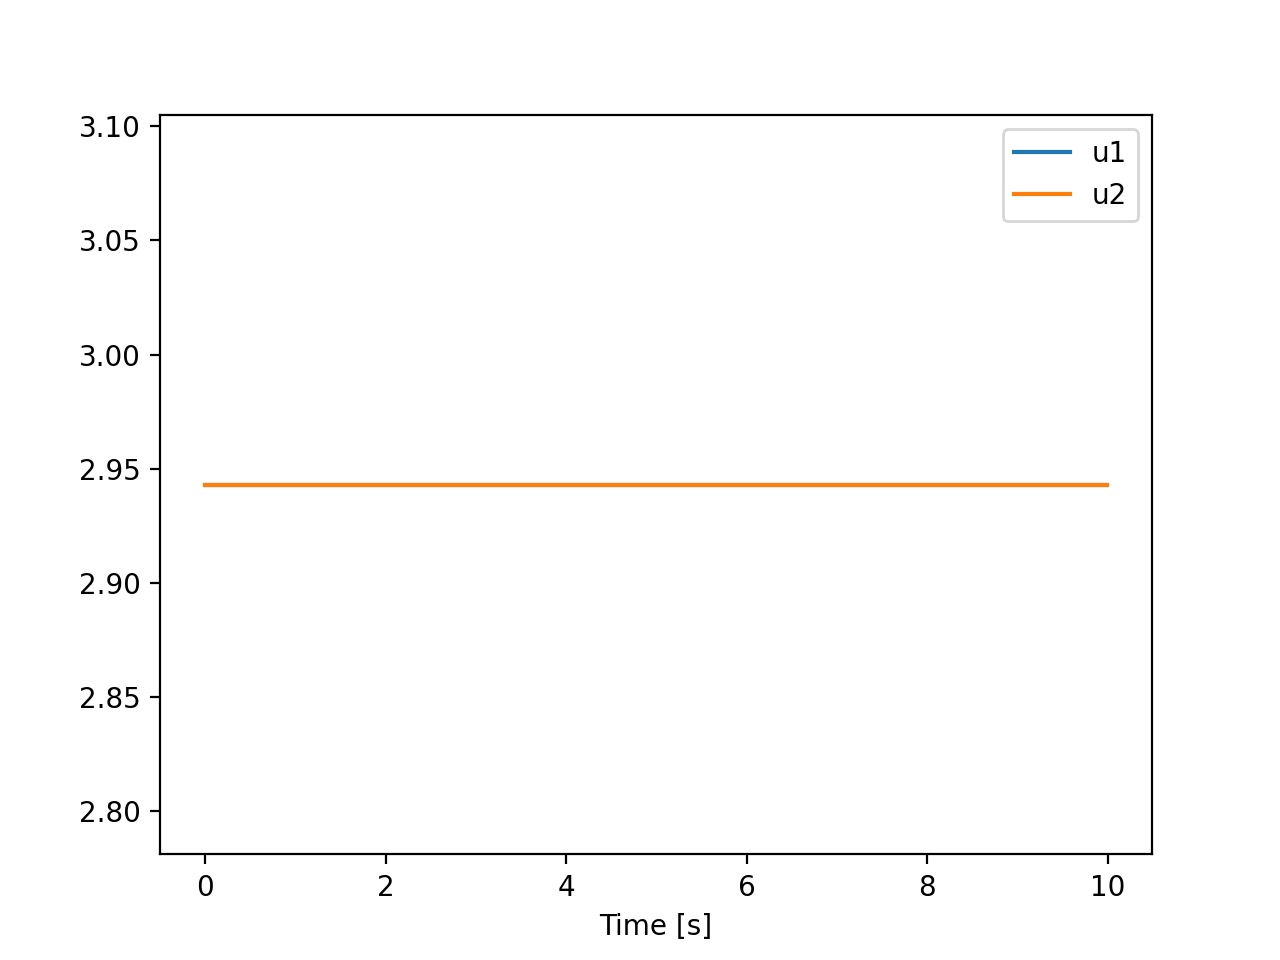

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAANvRtZGF0AAACsAYF//+s
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MSByMzAzME0gOGJkNmQyOCAtIEguMjY0L01Q
RUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMjAgLSBodHRwOi8vd3d3LnZpZGVvbGFu
Lm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5h
bHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhl
ZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAg
ZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0x
NSBsb29rYWhlYWRfdGhyZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGlu
dGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMg
Yl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dv
cD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFf
cmVmcmVzaD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9
MC42MCBxcG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAA
ABI2ZYiEABD//veBvzLLXyK6yXH5530srM885DxyXYmuuNAAAAMAAAMAAAMABiMSN/6H8XjN/AAA
AwAAtwAYUAwgCqgMKinu/ifupxALYZN8+DRFbIlw1mdkiD6azaJawFvXKBSEBkEKIJNbrApJO4Ci
3FIy2a4Xo17QlHD1I5W2HMvsrvSVkI71pLpwFT3Xg78hfbS8VYyKaLWmxTCU1aG5+7DS/2ZiBPtJ
6vuYv/3f7VvMeY/1llJtw9bYd+C2/5akaJ6Uuo8lZoaEGbyFQJg4HA7qOT5Vg9N/r8O7WKvfWfsv
mx8kXjRa8aN89hAOEASbBBWkcZQKo0oNRJZFVjJeWBxTFjD1eOFPP6/HvoGBxowngpWlWfAR+BRu
mVoJInEU+oobCndaVlkE6AmtcGFGulsWY9bXrKIHYcZ1oT+thVmulCoT81aUJXAvMWxJVeFoyHDI
qUgdhcLMjnuD44gxZoAmKrwXrDuOQjNHnZ8NaaktP8kzhTwfv7jmArIALhzWpB9WwCIgXIBbpCIj
0eR3Drxa5PEex3LDD+XAg9NDsxW8cce2l/FR02IVTJaZmpZXtWQ5f3BP8Aty1kv38ceulQsVhdJj
e6g0l0Bj6XmjYBLS5p2thXBovCDk56tcwW0pXAmn5ff2hXXmI5Gvl0rDaU9hZI3FzDNi13TNYmkS
Df1SKznomzDwO9GxtcvmIrv/fe/iXHegiYfM63XtT7KB/QMexVdErDPgye1hRQhTtdFfGt18np89
kb+wguO03mBEuG2kP8+d+MehIxeBeO3eFfFj/Z4NZ8x3GTT3P5UaYTJVYic6nO/ijtP6pqSv28GL
Fwfs7IFbK1YM+lDNrE+jaxfRKDwC7UVhCR1/k9yQp1EyCk1tdk7Vum4BWC4JSnxybhK3rwaCFMtb
dKuTa9hFCf4AE5KaaJY5j71oJC55DE17k+F5HKebHX1Q1MAAAAMAAAMAAAMAAT+GgbNftWCjdvG0
Ajp4M6ULjVCsreA+QcMDpOSHv8PDGxhrXuLpnP+1zeNjKnFSf7/D+MVytB5z6vGt+qAEfyTRDOPi
wWqV+MY/m/cAflfJcE4loJcs132DGO8MSEQoXpHrcwEP3/B0sRyxvhfQV/6rgUt9XpmqzXpxxip7
tK60jzWD/DPjVjrKNA0/DUztwfhkVOEO5OE3j/5mYHg3MBDZRhmvAsvQIhQIO2WQ0ZYKSAEO5ZOn
UAAhy2zdobHDvRIBG9997LI6eXnt2nVhrc6dRqiT9QejjW9erYmJIBqiCSA2zcTvl/5GKP6Bw4nB
3/rhN0/LNaXYUIQw3crtug/eqEVYnIUBKF97ZANr9HLowEBFR/k7ZSPwHzM5KOStJ2N8+wdyZ26R
75j48fwAAAMAAAMAAAMAAMg2u70zsKQjlFyFtw3pyekJ9CVJpBBRDMRi4zD7VLAUGix5NKFT/Xcp
Q9RjtycJs6Tm/LsHVS7++5Sy962no9rsn0PoztBeNoY6cRa/rZvLTVYSCkEjoxMRkIN+ch9NgoF9
FllLmRk5RzpfRdS48B8mMImNsFHa6AQWyTehFkksB8FbUvzrgsd1uhKHZuuM+R95nJtPdOBZ4S4a
chCgbiRxPGDNZQfcba1XCtzgZuF2t1MfsnKoGjGSNJiaapuMYuYOfbhvsn7xAzhAyr9wGTsZVXbq
QgSnxv3pmafnknDRjrkj6kLTyojsAR/52mSyGyzfOygOe+yPEkhP62rhFOL4krRKfTYyERugKmV/
ACFdaqiFtVlk+G5vtYSTQAMKtwyab+SYhpkZWY0TK4HvrK87/oduRWRmVMVeJ938Xv+O6Ag/eZwS
ttRhOkl5Wd88HCA9m/tRunhrESYOsYHWIqvfKO/Vozia8Utce9dK/X9ui5zYN+L2AAADAAADAAAF
X4M+Ss9ao3PeEyCC3JqmUeNo4io91+8DTa/B+l1GZoMA+AIuzdYXCPalY+OK8dF4mBfdcq5f80T9
1cYuOUPdb3CzK2vHUIJcACyIQRYCwC8vxmM3Os5NP8kMFNz3HM/e+0SukYBJsVdqJrH+Me1rpPYe
bx4+etW9zqH+zlJtFtWuydk9h1uX0UYhitC2qzKbVWhSak66PoQMMHTy36J7RVfIYAwDtN375lWI
v95ryDTxH7sVYtSFgxhx7paeO+bv25bw0YqlO1nSpJfhi8hf4ayH5wzsVuD8XSjNahMPt+ADPau9
qVCyapEO1U6tACLkbyIk7aD8tBQ1q/1NVs9KsoMK4iDipxYfSTX4sE0mAq3s4q8dKsOfnLfByg/+
mTJFOry8Qo86vV2dlpi/B4t1Z+WDQOm/AH4g7qp4DzJa/OKrRg/djw3cz1Kmi4hq4ReriR1hFkeZ
yR2on1zqIDXh6YoL/UOorimdy3ADDdLn+DfGvM06Q/ZCzUPE0D8mN+M4UpctWxTloUMWVYvALb9P
mtKwUrc4Eg2HEGqT7CqAnv2OLryUJETFIyA19h7UfppwYQJJQaZXED31LYzWHuOa+NrezbLypvft
K3N4qUfbsVud0oGF0yO7r3jU02z17s6NBusQIBorOh299mU1nYLhd2BvUAUat8GyP18+uXGHW1OL
zsnE16UInN6hPNHYCnWXUo4HH1+RE7rsa1ylASATfQPq+vRClzlZzo+7zj35P/f1LQdbupswohFT
my1YSpbuBrbRU4ymIjks85URfNekynSBfbW7bR3qdcFNp9rf23XDT7SpSy3Uz1z1bsLhk07/HDf+
dfabmXkObNdwU9m1QrjGos3wPzRBKfV/QABwMN1aQQ0o+L4Bii0MeFiGwRQqfXN1KAAAAwAAAwHb
YMuX/qETK00XMIIDbtq+KJNQ7TB0aFKwIyQ4+3af1apse3RcbVjUc3NKjbRbD5e0w6aBd2WgL33R
UMzZur48IujZJ91iOACOW

In [7]:
# we can also simulate with perturbations
t, state, u = quadrotor.simulate(z0, dummy_controller, horizon_length, disturbance = True)

# we can plot the results
plt.figure(figsize=[9,6])

plt.subplot(2,3,1)
plt.plot(t, state[0,:])
plt.legend(['X'])

plt.subplot(2,3,2)
plt.plot(t, state[2,:])
plt.legend(['Y'])

plt.subplot(2,3,3)
plt.plot(t, state[4,:])
plt.legend(["theta"])

plt.subplot(2,3,4)
plt.plot(t, state[1,:])
plt.legend(['Vx'])
plt.xlabel('Time [s]')

plt.subplot(2,3,5)
plt.plot(t, state[3,:])
plt.legend(['Vy'])
plt.xlabel('Time [s]')

plt.subplot(2,3,6)
plt.plot(t, state[5,:])
plt.legend(['omega'])
plt.xlabel('Time [s]')

# we can also plot the control
plt.figure()
plt.plot(t[:-1], u.T)
plt.legend(['u1', 'u2'])
plt.xlabel('Time [s]')

quadrotor.animate_robot(state,u)

# Part 2

In [8]:
def get_linearization(z,u):

    theta = z[4]
    
    u1 = u[0]
    u2 = u[1]
    
    
    A = np.eye(6)
    B = np.zeros(shape=(6,2))

    A[0][1] = quadrotor.DELTA_T
    
    A[2][3] = quadrotor.DELTA_T
    
    A[4][5] = quadrotor.DELTA_T
    
    A[1][4] = -quadrotor.DELTA_T*((u1+u2) * np.cos(theta) / quadrotor.MASS)
    
    A[3][4] = -quadrotor.DELTA_T*((u1+u2) * np.sin(theta) / quadrotor.MASS)

    
    B[1][0] = -quadrotor.DELTA_T*np.sin(theta) / quadrotor.MASS
    
    B[1][1] = -quadrotor.DELTA_T*np.sin(theta) / quadrotor.MASS
    
    B[3][0] = quadrotor.DELTA_T*np.cos(theta) / quadrotor.MASS
    
    B[3][1] = quadrotor.DELTA_T*np.cos(theta) / quadrotor.MASS
    
    B[5][0] = quadrotor.DELTA_T*quadrotor.LENGTH / quadrotor.INERTIA
    
    B[5][1] = -quadrotor.DELTA_T*quadrotor.LENGTH / quadrotor.INERTIA
    
           

    return A,B

In [9]:

def solve_gains(A,B,Q,R,P):
    A_t = np.transpose(A)
    B_t = np.transpose(B)
    
#     print(B)
#     print(B_t)
    
#     P = Q
    
    

    P1 = Q 
    
    P2 = np.matmul(A_t,np.matmul(P,A))
    
    
    P3_1 = np.matmul(np.matmul(A_t,P),B)
    
    pPar1 = np.matmul(P,B)
    pPar2 = np.matmul(B_t,pPar1)
    pPar = pPar2 + R                  
    P3_2 = np.linalg.inv(pPar)
    
    
    P3_3 = np.matmul(B_t,np.matmul(P,A))
    
    P3 = -np.matmul(P3_1,np.matmul(P3_2,P3_3))
                    
        
    P = P1 + P2 + P3                

    
    
    KPar_ = np.matmul(B_t,np.matmul(P,B))
    KPar = KPar_ + R
    inKPar = np.linalg.inv(KPar)
    
    K2 = np.matmul(B_t,np.matmul(P,A))
    
    K = -np.matmul(inKPar,K2)
    
    
    
    
    return K,P
    
    

In [10]:
Q = 1000*np.eye(6)
Q[4][4] = 1000
Q[5][5] = 1000
R = 10 * np.eye(2)



z0 = np.zeros([quadrotor.NUMBER_STATES,])




In [11]:
def stability_controller(state,i):
    ustar = quadrotor.MASS*quadrotor.GRAVITY/2. * np.ones([2,])
    speed = 1
    
    zstar = np.zeros(shape =(6,))

    
    
    
    A,B = get_linearization(state,ustar)

    K_,P_ = solve_gains(A,B,Q,R,P[i])
    
    K.append(K_)
    P.append(P_)

    u = np.matmul(K_, state-zstar)+ustar

    return u

<IPython.core.display.Javascript object>


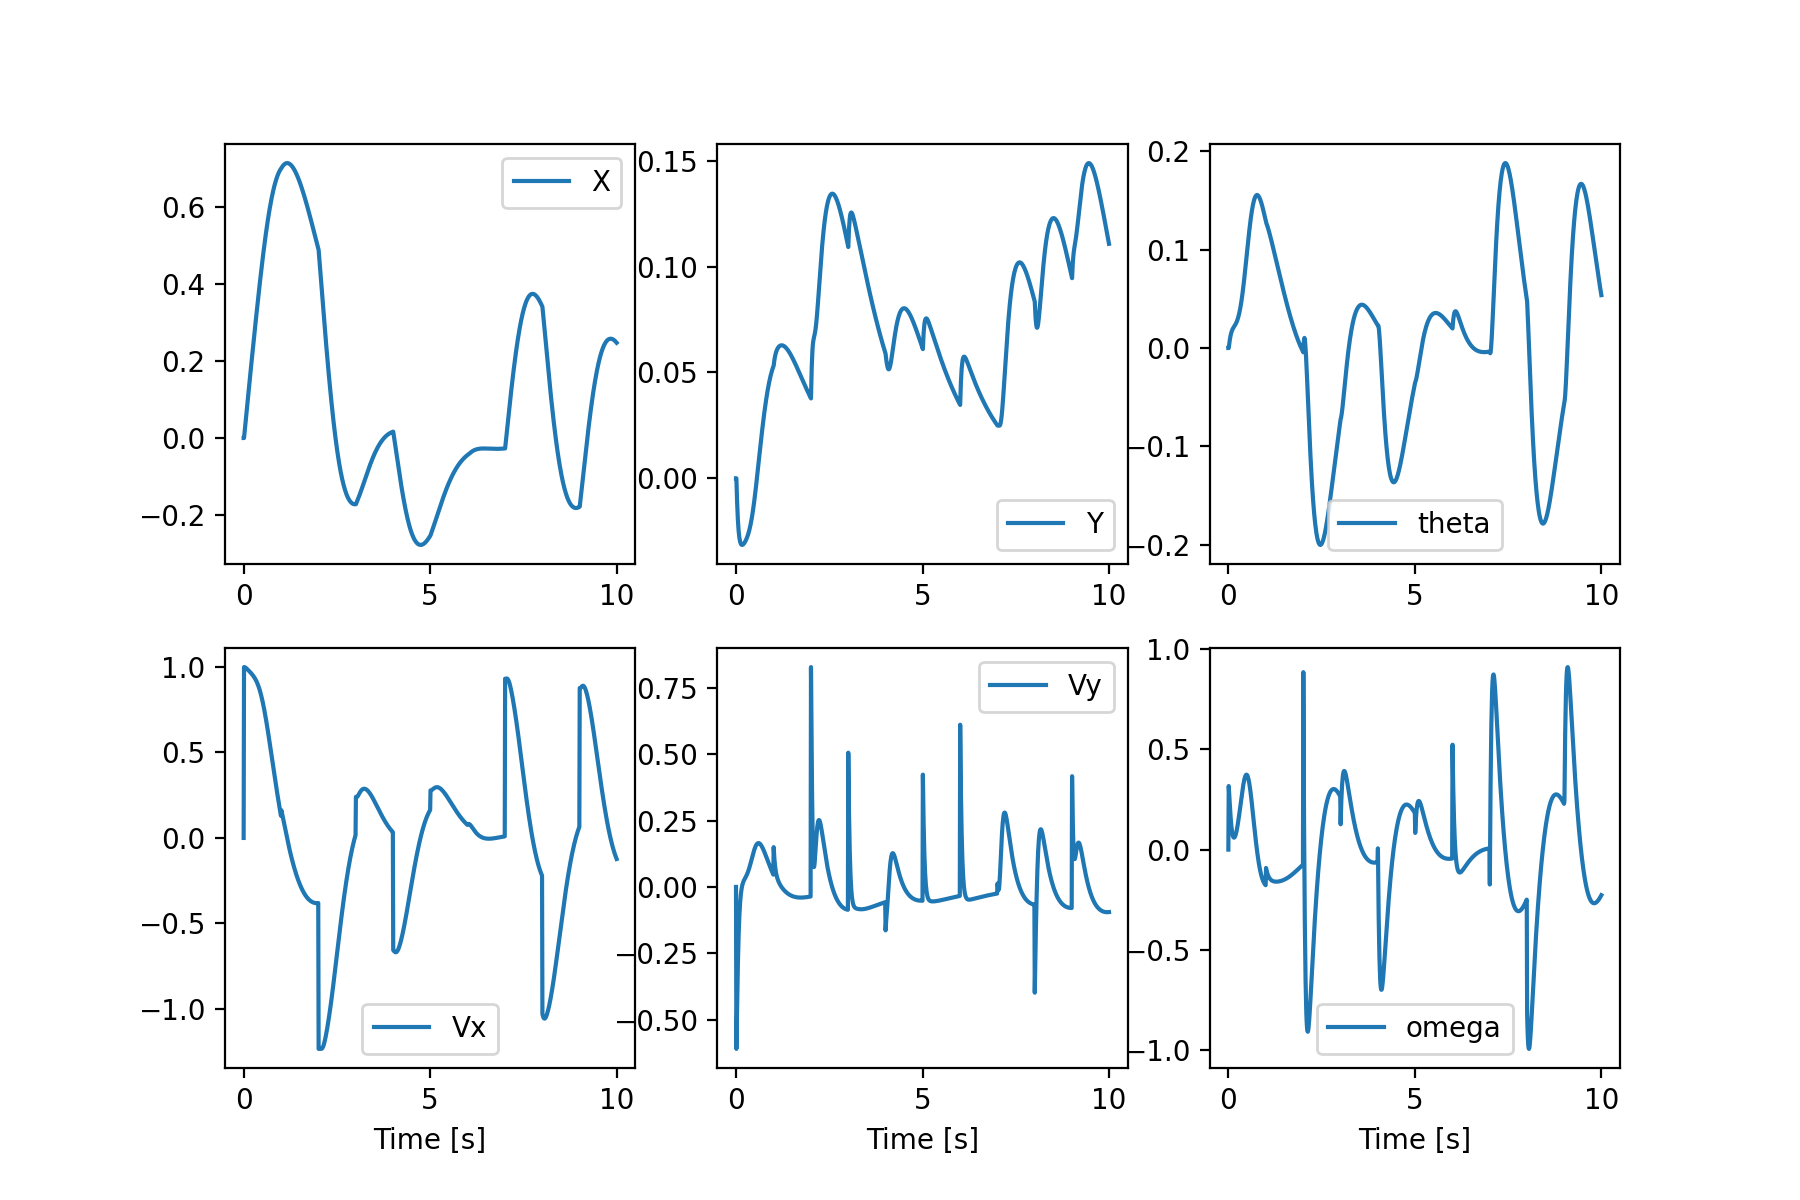

<IPython.core.display.Javascript object>


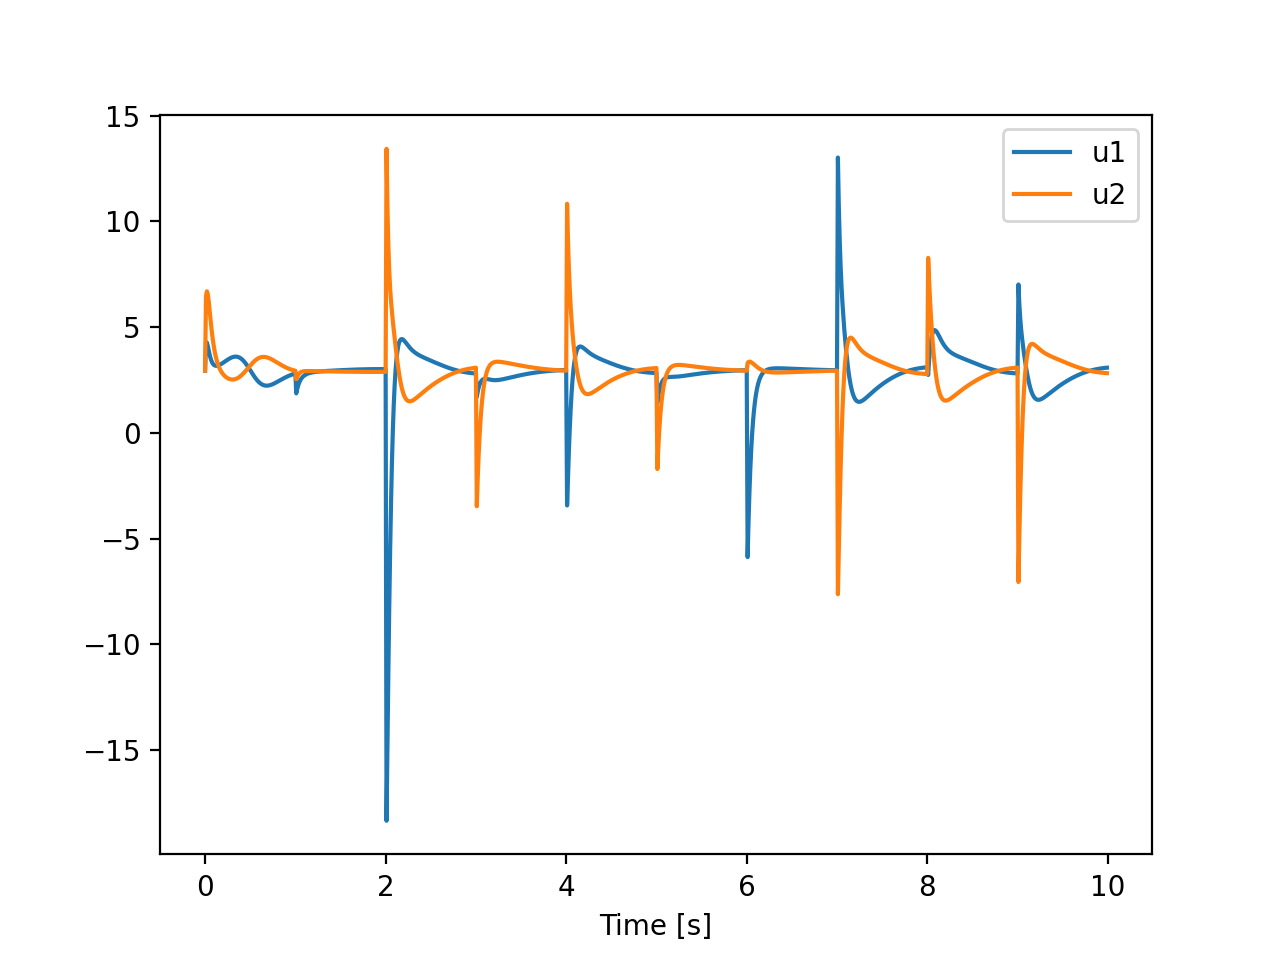

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAbdttZGF0AAACsAYF//+s
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MSByMzAzME0gOGJkNmQyOCAtIEguMjY0L01Q
RUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMjAgLSBodHRwOi8vd3d3LnZpZGVvbGFu
Lm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5h
bHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhl
ZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAg
ZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0x
NSBsb29rYWhlYWRfdGhyZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGlu
dGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMg
Yl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dv
cD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFf
cmVmcmVzaD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9
MC42MCBxcG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAA
ABI6ZYiEABD//veBvzLLXyK6yXH5530srM885DxyXYmuuNAAAAMAAAMAAAMABiMSN/6H8XjN/AAA
AwAAtwAYUAwgCqgMKinu/ifupxALYZN8+DRFbIlw1mdkiD6azaJawFvXKBSEBkEKIJNbrApJO4Ci
3FIy2a4Xo17QlHD1I5W2HMvsrvSVkI71pLpwFT3Xg78hfbS8VYyKaLWmxTCU1aG5+7DS/2ZiBPtJ
6vuYv/3f7VvMeY/1llJtw9bYd+C2/5akaJ6Uuo8lZoZnnRH1MGgEGNDTXiPTf6/Du1ir9Xf4AnWg
JdxovNaN89stdLUVnCCtI4ygVVLk4WfkLBy9I7rimLGHq8cKrQ5cQg3iLXa5SyHuvA1l78Cjsg2B
xEnEWFPAQlW2BvglC/S3wbwBS3TCrMfGhS9IB2HGdaE/rYVZrpQqE/NWlHVwLzVsSVXhaMhwyKlI
HYXCzI57hSY6Xk5AJsq8kL3L0uFd6dPBL2cLN/FxfVLT2/XnAZ8AFe5rUg+goA5ALkAt0hER6PI7
h14tcniPY7lhh/LgQemh2YreOOPbS/io6bEKpktMzUsr2rIcv7gn+AW5ayX7+OPXSoWKwukxvdQa
S6Ax9LzRsAlpc07Wwrg0XhByc9WuYLaUrgTT8vv7QrrzEcjXuaVhtKewskbi5hmxa7pmsTSJBv6p
FZz0TZh4HejY2uXzEVm/xVgXpMd9z3rmdbr2p9lA/oGPYquiVhnwZPawboQp2uivjW6+T0+eyN/Y
QXHabzAiXDbSH+fO/GPQkYvAvHbvCvix/s8Gs+Y7jJp7n8qLaqTasugft+bqVek2YBBut8pPDICm
8tvCV9mmpWnTtgAm48T4dp+9EoPALoApPxQKv4VR25aTzSwgYRz150VuCWROyt/HJqH47xjkZQy1
t0q5Nr2EUP/gTsIubx3MlVw/rC54yKg7wfC8jlPOFxaIamAAAAMAAAMAAAMAAJ/DQNmv2rBWu3za
AR08GdKFxqhWVvAdZecB0nJD3+HhjYw0/3F0zn/a5vMxlTipP9/h/GK5Wik59XjW/VACP5JohnHs
ln+yKf/s1pRZ+AeWIlMEVD3P3KDBjHeGJCIUL0j1ttTuLdu9DK5Gt4DF6H+q81bFTeNVYq2whDMx
z+eeBonYSUUD/51lGga/M8yjGJ78BaEO5Sk3j/5mYHg3MBDxRhmvArO+iWwJ5cqMYDx0kAIdyydO
oABDltm7Q3Nt1TgIQQp3yNIp5ee3adWGtzpzV1xbhxsca3sBbExJANUQSQG2bbFEv/IxR/QOHE4O
/767j/yzWl2FCEMN3K7boP3qhFWGyFAShfe2QDa/Xy6MBARUf5O2S79U+6/JQ2niMMpYpnDlN2D2
+MDHj+AAAAMAAAMAAAMABkG13emdrSIcouQtuG9OT0hPoT5NIIKIZiMXGYfYpYCg0WPJpQqf7blK
HqMdwnlNnSc35dg6qXf4zKdVsURmj2uyfQ+jO4L7pTV+gbS+PBobfnjTzGaIFX+LRXEqCT02CgX0
WWUuZGTlFOl811LjwHyYwiY2wUlroBBbJN6EVCSwHwVtS/VLyx3W6Eodm640QCPWbAFr3XOnqZMo
te7XuRvejH81lB9xt08SK3OBm4Xa3Ux++cqgaMZI0mJpqm6xi5g59uG+yfvEDaJ+xYXAZOxlVduo
sUCfG/emZp+eScfGOuSPqQtPKiOwBH/miuQ/bLN87KA577I8mSE/rauEU4viStEp9NjIRG6AqZX8
cam4vboW1WWT4bm9lslbvPprInow+ycZkOZNFQmVYdhJ287/odwhehmVMVeJ938Xv+O6AhBeZwSt
tRhOkl5Pd1jl/D9m/tOt5ea+J6bNNzKLLkUhaE9fIg2ssmhkvKWPUtPAAAADAAADAAAJLyK8lZ61
Rue8SjtOYy52albOOKXCOhi6yvwfpdUa1IWxETHIS0KP9J6zSJfWIMs2elgchckOrJN8o0pL2MMG
c0yquNV2W/738aJ5qq+k11NOd5kELxYDxxDNT9DCwwWVYyhdvroFHSvN3gE9z2WvWEf7AzoPDNp5
Gobj1Y+WSMrmIjdrNF+UELm89VcIUZcqIHXNW1QxVaFJqTro+hAxPUZio82VhhW/viP62Xv5Rr3t
w/SmC4FTXfAORoP2pWFdSB7AWwJGWJgQLH3m5I2FoxVKdrOlQFUtg7EMa8QIg0y7IDdmGKCAbkQW
sc/PhNNLocI5o9hsVRU7k/UeCnz1snsviERM4n5/Hxxy3UiOtkR/f9arX1rbrI09fhea8hEshjvb
rl8yLiqL36GP74k+4fy/0NvxxoHrZePzTx62Yb/1tq/lS1Rhr82DwBAhmQ2iu5A3bkcCmRhMbatP
5kA4/l4DozfIbQop9qYgE7lP/Bw7XIPcEGl1sjXE+HyRqIdBYzUVpYUi+nDN5sfivNPMu+iHIrQK
pd127MZ6U56Xht4DT1YCiatkQCFUksyJEKJHrA3s8BWHb2qeo5JKMR2ofYyxpuE4WIR75dhM3KQ2
6pGR27XX3RsOKiwu63LgegQFhiaH6qi050vceaMyb3pxnEJ6PzHVDXgW0kiywt98G0sB1SKEW9LR
qOugTQIHxpgRbML+RJ8AGwj1UKDJ8TUetGCElZOk7AXgJm5JA4+vyIndoe0udivCzJBiefY/YVP3
f5E1d8D78n/uW1s+6TIy3lpt+yX21SEFIsdwATMi5XmFSqG/FSd3mVYKmGy312KoGSIKIXz9Vjje
Vt1CN4VYjhJLI1Nry7Fz1tE8ZW/T5q4XRQgDABK0AWoABdgBFnK5P3c+qSMT2Xit9gAAAwAAAwIk
iLYNPOxm4xgCWnLutQmtUVdz4VQjuFZuwVblpE9Io5gUhgKyMi4D2nn5dqTSZsl0ZAfiZqwYLsmM
ZRtG50O3nJq2rzTqO8neg

In [12]:
K = []
P = []
P.append(Q)

# we can also simulate with perturbations
t, state, u = quadrotor.simulate(z0, stability_controller, horizon_length, disturbance = True)

# we can plot the results
plt.figure(figsize=[9,6])

plt.subplot(2,3,1)
plt.plot(t, state[0,:])
plt.legend(['X'])

plt.subplot(2,3,2)
plt.plot(t, state[2,:])
plt.legend(['Y'])

plt.subplot(2,3,3)
plt.plot(t, state[4,:])
plt.legend(["theta"])

plt.subplot(2,3,4)
plt.plot(t, state[1,:])
plt.legend(['Vx'])
plt.xlabel('Time [s]')

plt.subplot(2,3,5)
plt.plot(t, state[3,:])
plt.legend(['Vy'])
plt.xlabel('Time [s]')

plt.subplot(2,3,6)
plt.plot(t, state[5,:])
plt.legend(['omega'])
plt.xlabel('Time [s]')

# we can also plot the control
plt.figure()
plt.plot(t[:-1], u.T)
plt.legend(['u1', 'u2'])
plt.xlabel('Time [s]')

quadrotor.animate_robot(state,u)

# Part 3

In [13]:
Q = 200*np.eye(6)
Q[4][4] = 0.02
Q[5][5] = 0.02
R = 1 * np.eye(2)

K = []
P = []
P.append(Q)

z0 = np.zeros([quadrotor.NUMBER_STATES,])
z0[0] = 1
# z0[4] = np.pi/4



In [14]:
def circle_controller(state,i):
    ustar = quadrotor.MASS*quadrotor.GRAVITY/2. * np.ones([2,])
    speed = 1
    
    zstar = np.zeros(shape =(6,))
    zstar[0] = np.cos(speed*i*quadrotor.DELTA_T)
    zstar[1] = -speed*np.sin(speed*i*quadrotor.DELTA_T)
    zstar[2] = np.sin(speed*i*quadrotor.DELTA_T)
    zstar[3] = speed*np.cos(speed*i*quadrotor.DELTA_T)

    
    
    
    A,B = get_linearization(state,ustar)

    K_,P_ = solve_gains(A,B,Q,R,P[i])
    
    K.append(K_)
    P.append(P_)

    u = np.matmul(K_, state-zstar)+ustar

    return u

<IPython.core.display.Javascript object>


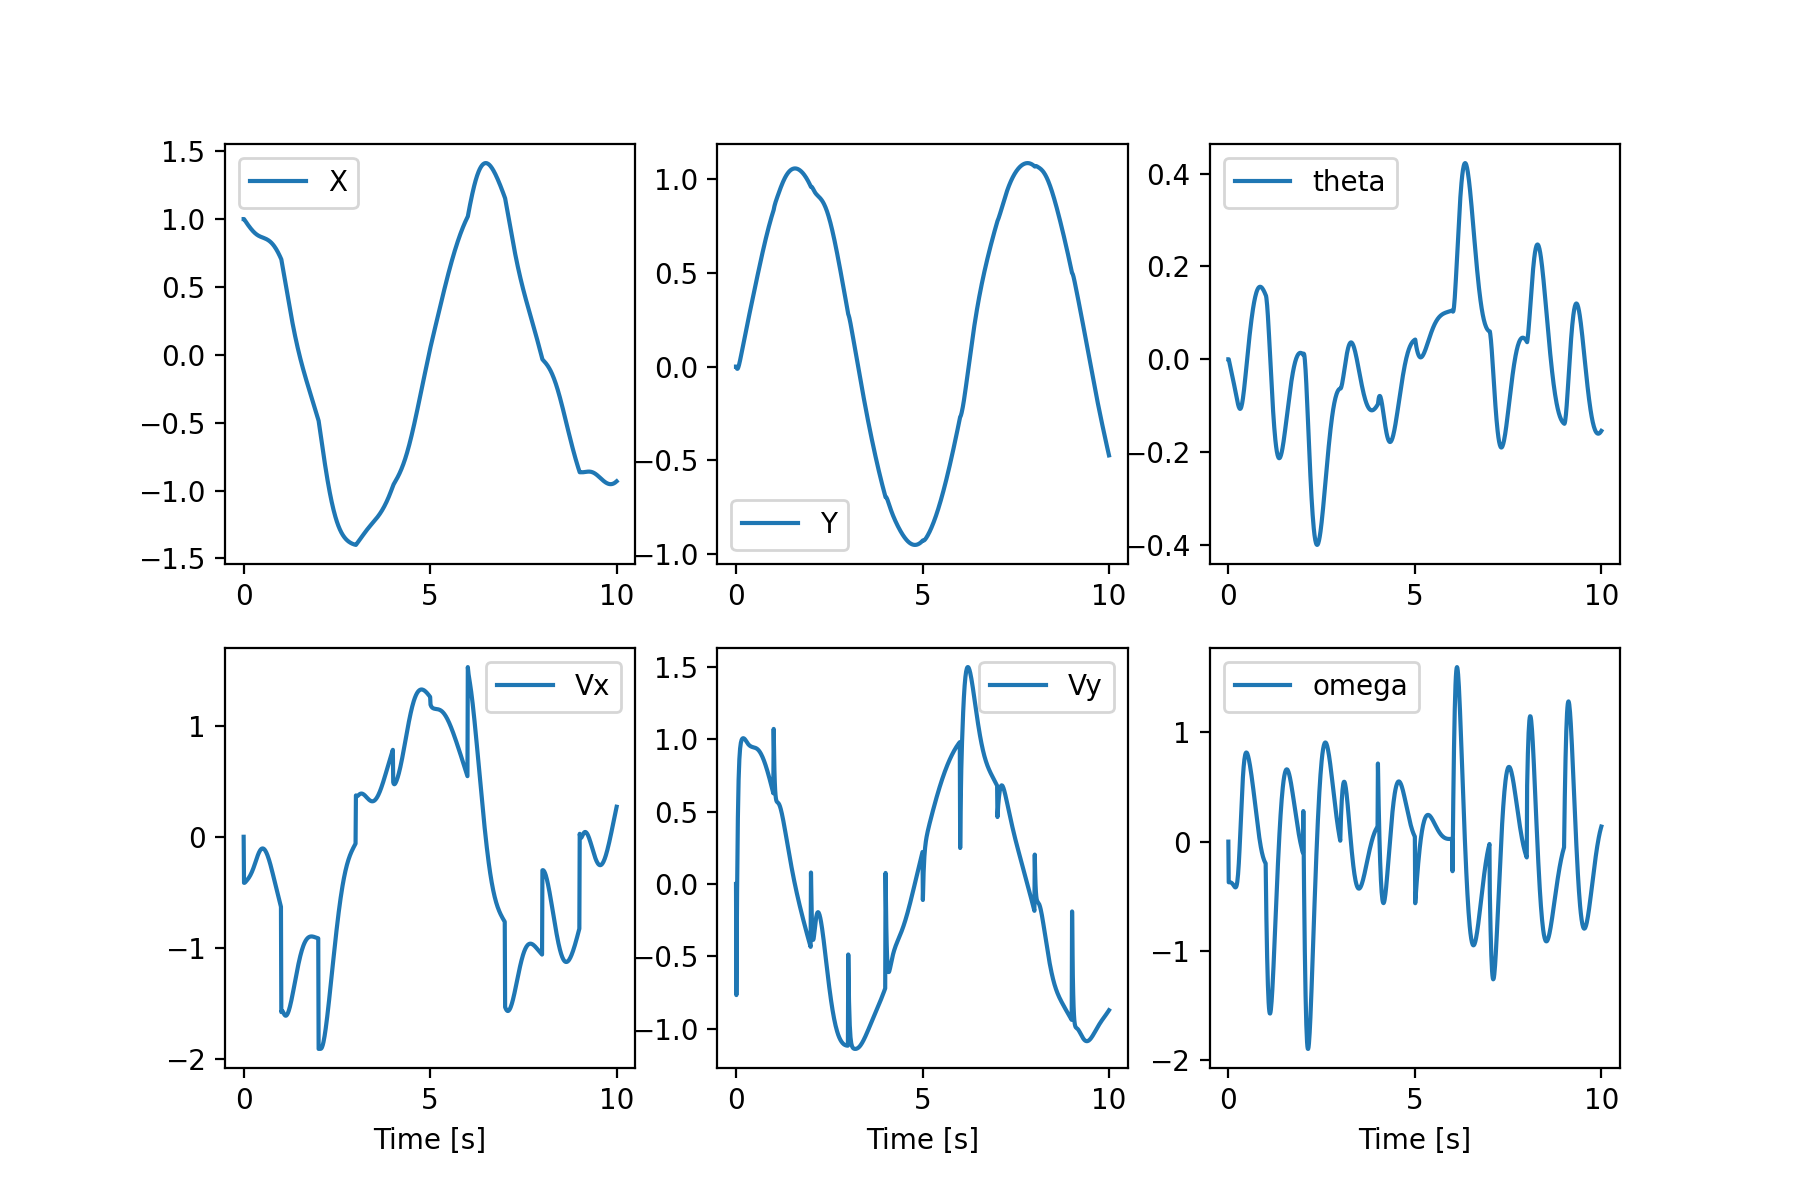

<IPython.core.display.Javascript object>


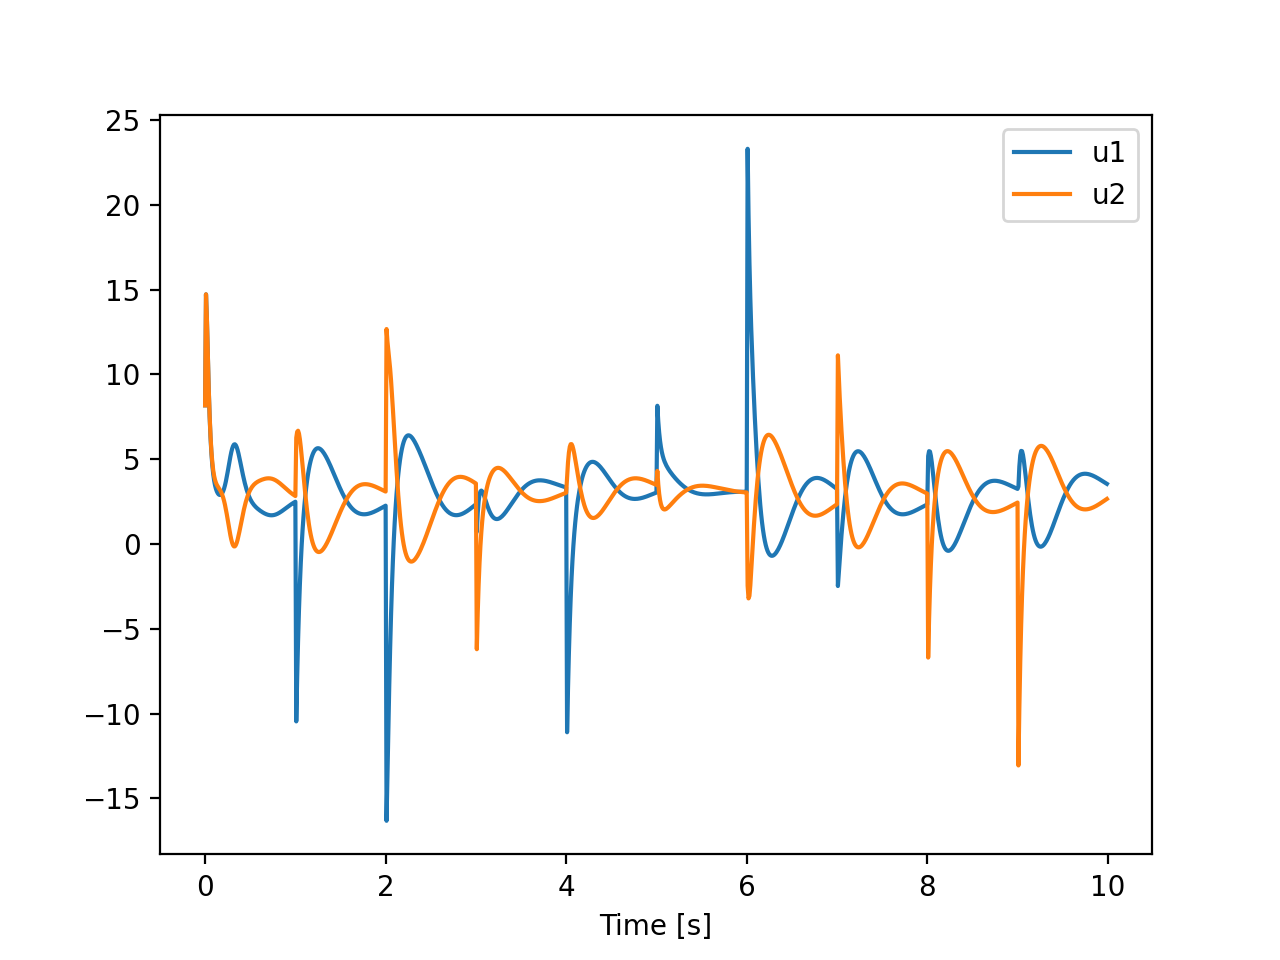

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAhbxtZGF0AAACsAYF//+s
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MSByMzAzME0gOGJkNmQyOCAtIEguMjY0L01Q
RUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMjAgLSBodHRwOi8vd3d3LnZpZGVvbGFu
Lm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5h
bHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhl
ZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAg
ZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0x
NSBsb29rYWhlYWRfdGhyZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGlu
dGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMg
Yl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dv
cD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFf
cmVmcmVzaD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9
MC42MCBxcG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAA
ABJRZYiEABD//veBvzLLXyK6yXH5530srM885DxyXYmuuNAAAAMAAAMAAAMABiMSN/6H8XjN/AAA
AwAAtwAYUAwgCqgMKinu/ifupxALYZN8+DRFbIlw1mdkiD6azaJawFvXKBSEBkEKIJNbrApJO4Ci
3FIy2a4Xo17QlHD1I5W2HMvsrvSVkI71pLpwFT3Xg78hfbS8VYyKaLWmxTCU1aG5+7DS/2ZiBPtJ
6vuYv/3f7VvMeY/1llJtw9bYd+C2/5akaJ6Uuo8lZoaEGbyFQJg4HA7qOT5Vg9N/r8O7WKvfWfsv
mx8kXjRa8aN89hAOEASbBBWkcZQKo0oNRJZFVjJeWBxTFjD1eOFPP6/HvoGBxowngpWlWfAR+BRu
mVoJInEU+oobCndaVlkE6AmtcGFGulsWY9bXrKIHYcZ1oT+thVmulCoT81aUJXAvMWxJVeFoyHDI
qUgdhcLMjnuD44gxZoAmKrwXrDuOQjNHnZ8Nyakw+tJVBHP/CT5YB/ZO0KJm0WD9AHABRAFukIiP
R5HcOvFrk8R7HcsMP5cCD00OzFbxxx7aX8VHTYhVMlpmalle1ZDl/cE/wC3LWS/fxx66VCxWF0mN
7qDSXQGPpeaNgEtLmna2FcGi8IOTnq1zBbSlcCafl9/aFdeYjka+XSsNpT2FkjcXMM2LXdM1iaRI
N/VIrOeibMPA70bG1y+Yiu/+eZfgrlBEJh8zrde1PsoH9Ax7FV0SsM+DJ7WFFCFO10V8a3Xyenz2
Rv7CC47TeYES4baQ/z534x6EjF4F47d4V8WP9ng1nzHcZNPc/lRphMlViJzqc7+KO0/qmpK/bwYs
XB+z5hFXW9DVFeYKJ9G1i+iUHgF4wnhlVcMi7rTQiImFXra7J2rdNwCsH1Tv34upH9vYw0DoyDMF
ytRDj+gd/y6XyU00SxzH5TQSFzyHVt3J8LyOU9QOvqhqYAAAAwAAAwAAAwAAn8NA2a/asFHxtweb
0TwZ0oXGqFZW8B5w4YHSckPf4eGNjDWvcXTOf9rm83GVOKk/3+H8YrlaGzn1eNb9UAI/kmiGcfNg
tUr8Yx/N+4A/K+S4JxLQS+MUvsGMd4YkIhQvSPW5gIfv+DpYjljfC+gr/1XApb6vTNVmvZDjFT3a
V1qT6sH+GfGrHWUaBy+Gpndg/DIqcIeKvJvH/zMwPBuYCGyjDNeBZegRCgQdsshoywUkAIfyCdOo
ABDltm7Q2OHeiQCN7772WR08vPbtOrDW506jVEn6g9HGt69WxMSQDVEEkBtm4nfL/yMUf0DhxODv
/XCbp+Wa0uwoQhhu5XbdB+9UIqxOQoCUL72yAbX6OXRgICKj/J2ykfl4JZyUclaTsb59g7kzt0j3
zHx4/gAAAwAAAwAAAwAAZBtd3pnYUhHKLkLbhvTk9IT6EqTSCCiGYjFxmH2qWAoNFjyaUKn+u5Sh
6jHbk4TZ0nN+XYOql399yll71tPR7XZPofRnaC8bQx04i1/WzeWmqwkFIJHRiYjIQb85D6bBQL6L
LKXMjJyjnS+i6lx4D5MYRMbYKO10Agtkm9CLJJYD4K2pfnXBY7rdCUOzdcZ8j7zOTae6cCzwlw05
CFA3EjieMGayg+5qBVH+MaObOxtEw2Cw+Cdc4pka6Klwoq3S6cO1rQkR3omdcY2+brNNmr10eJEI
KH9KMsD/j0RNMnnhZ9sIwEJPdxf+BxGNaRGiaJWz3cit7pJIu7qpbfdf1XTIeOU3BakA2eZ7lJp+
olfedftjimjPw80cCXFtkqHkO6jz7odtjnkGuezcXXbpU6RsWMHYZMteAccERi/WxqwwgBmRVT/R
DSsZcPYXhnDnAvyM330jLjW0o5acgpL7t27kcyO82ow2dknObbI/SCyniD7scyEazZ/DXAKAAAAD
AAEYXAPZB/WCVuQbg/TPX0oZvd6C1fR1Dvkvu50noctiERb4D7LW7FB3YZxxY8feYdEEHYLHlQAD
4dlQCaCfPVDqjjSlE/jis+u7R2hU81zT0Q5QFeGH9pLjwHIzbhukuc7nXjhrmrHH+58AAgIMhoRo
ywbFSmf9EQvI5EvNOuvwIz0R5vkK/qfLNGRzQ5u356QrybavkK8sZRosrhUE9z/lh6jz8WKC3Krz
ZYJhfr+DUxeRQ3cGk+TbaLJMmVgl5BvSzvX1RNanW8+/vMh1MuSp7oHGSH81DUmwEVFX8ZY2Q/E7
gwZJYYgTN3V2V2hwzhbomd2vfuXAsx74AZsdmO/967609w8/o/QPWVEsO5GejDYMlkqwPqUlK1+K
fSbEJTIS951d14JeW0LIo8yR/Vfbw7MrOAhi069LK7LQHX2nsym8bcwtPTAXpbDl/CuNLj/64voR
+vNMP0x5/95MPkTvyY2IY3DEQTfFCDf9sDgXlXcx0wjDxoC+miim3i8omV0HVz1QgpSZ5KsYUgrL
FD3JciVnBr+FGdeIQZP6XT2j9r/X9dpLaPTNbnpnkteVJHWOQcUxusnB3pGoXQctwF67o50TYfGx
CgqcF25m5Q63iGDqjedfuCZVW6dr/3jRjQlJvD+bG9ybhSv+H2BIld4bReBYkCst5fCdWWhc90i9
9AmBnVIao+h9ppz3GolPG6bzgEqKFT2t4pRY0rzfEng7gt2DOFPeuDPdgLOKFuoiREp7ldwFmZUt
XdwC32fEaWptzUrBCfvW1klKiv9Df/p6cSWs6nlQ0KYmqI0hqR/mwnUA1LLmrh/nmu/NnzWOy5R3
Yadh1Bj+Qerf///o+k7nK2AGu2mPv8q4h2kCiIzPqRNQlhxNfickACU5Mq2o1v/DeQyENjoPa1fy
TQAdPD9K3PrTw9L2q6YrYsIAAAMAA2q8jkEWIXOt//STOcEYSyJ6HBzjkZ76kYbMSTEEcdCGOdLM
BWRkXAL+nhl67eUrplD6N

In [15]:
# we can also simulate with perturbations
t, state, u = quadrotor.simulate(z0, circle_controller, horizon_length, disturbance = True)

# we can plot the results
plt.figure(figsize=[9,6])

plt.subplot(2,3,1)
plt.plot(t, state[0,:])
plt.legend(['X'])

plt.subplot(2,3,2)
plt.plot(t, state[2,:])
plt.legend(['Y']) 

plt.subplot(2,3,3)
plt.plot(t, state[4,:])
plt.legend(["theta"])

plt.subplot(2,3,4)
plt.plot(t, state[1,:])
plt.legend(['Vx'])
plt.xlabel('Time [s]')

plt.subplot(2,3,5)
plt.plot(t, state[3,:])
plt.legend(['Vy'])
plt.xlabel('Time [s]')

plt.subplot(2,3,6)
plt.plot(t, state[5,:])
plt.legend(['omega'])
plt.xlabel('Time [s]')

# we can also plot the control
plt.figure()
plt.plot(t[:-1], u.T)
plt.legend(['u1', 'u2'])
plt.xlabel('Time [s]')

quadrotor.animate_robot(state,u)

# Part 4.1

In [16]:
def get_coeff(n):
    dt = quadrotor.DELTA_T
    t = dt*n
    u_static = quadrotor.MASS*quadrotor.GRAVITY/2
    u_star = np.array([u_static,u_static])
    z_star = None
    r = np.zeros((2,1))
    q = np.zeros((6,1))
    Q = np.eye(6)
    R = np.eye(2)
    
    if t<4.0:
        Q *= 10
        R *= 100
    elif t<5.0:
        Q *= 1
        R *= 1
    elif t== 5.0:
        Q = 2000*np.array([[50,0,0,0,0,0],[0,0,0,0,0,0],[0,0,50,0,0,0],
                              [0,0,0,0,0,0],[0,0,0,0,50,0],[0,0,0,0,0,0]])
        R *= 1
        z_star = np.array([3,0,3,0,np.pi/2,0])
        u_star = None
        q = -np.matmul(Q,np.reshape(z_star,(6,1)))
    elif t<5.25:
        Q *= 1
        R *= 1
    else:
        Q *= 10
        R *= 10
    
    if u_star is not None:
        r = -np.matmul(R,np.reshape(u_star,(2,1)))
    
    return Q, R, q, r


    

In [17]:
def get_quadratic_approximation_cost(z,u, horizon_length):
    hesU = []
    jacobU = []
    hesZ = []
    jacobZ = []
    


    for i in range(horizon_length-1):
        hesU.append([])
        jacobU.append([])
        hesZ.append([])
        jacobZ.append([])
           
    hesZ.append([])
    jacobZ.append([])
    
    for i in range(horizon_length):
        Q,R,q,r = get_coeff(i)

        
        jacobZ[i] = np.matmul(z[:,i],Q) + np.transpose(q)
        hesZ[i] = Q

        try:
            jacobU[i] = np.matmul(u[:,i],R) + np.transpose(r)
            hesU[i] = R
        except:
            pass
        
    return jacobZ, jacobU,hesZ,  hesU
    
    

In [18]:
def compute_cost(z,u,horizon_length):
    cost = 0
    for i in range(horizon_length-1):
        Q,R,q,r = get_coeff(i)
        cost += .5*(z[:,i])@Q@np.reshape(z[:,i],(6,1)) + .5*(u[:,i])@R@np.reshape(u[:,i],(2,1)) + r.T@np.reshape(u[:,i],(2,1)) + q.T@np.reshape(z[:,i],(6,1))
    cost += .5*(z[:,-1])@Q@np.reshape(z[:,-1],(6,1)) + q.T@np.reshape(z[:,-1],(6,1))
    return cost

In [19]:
horizon = 1001
arb_u = np.ones((2,horizon-1))*quadrotor.MASS*quadrotor.GRAVITY/2
arb_x = np.zeros((6,horizon))

for i in range(1,horizon):
    arb_x[:,i] = quadrotor.get_next_state(arb_x[:,i-1],arb_u[:,i-1])
# This represents the quadratic approximation of the arbitrary trajectory
# There are jacobians and hessians with respect to z and u for every time step
jz, hz, ju, hu = get_quadratic_approximation_cost(arb_x,arb_u,horizon)



In [20]:
def solve_LQR_trajectory(arb_u,horizon):

    

#     arb_u = np.ones((2,horizon-1))*quadrotor.MASS*quadrotor.GRAVITY/2

    arb_x = np.zeros((quadrotor.NUMBER_STATES,horizon+1))
    
    for i in range(1,horizon):
        arb_x[:,i] = quadrotor.get_next_state(arb_x[:,i-1],arb_u[:,i-1])
    
    x = arb_x
    u = arb_u
    
    # I could have done less iterations or put in some logic to stop it at a certain point, but this does not take very much time as is
    for ix in range(50):
        
        
        jacobZ,jacobU,hesZ,hesU =  get_quadratic_approximation_cost(x, u, horizon)
        Pn =hesZ[-1]
        pn =np.transpose(jacobZ[-1])

        K_gains = []
        k_feedforward = []
        for i in range(horizon-1):

            K_gains.append([])
            k_feedforward.append([])
        
        #Riccotti equations with approximation of cost
        for i in range(horizon-2,-1,-1):
            A,B = get_linearization(x[:,i],u[:,i])
            R = hesU[i]
            Q = hesZ[i]
            r = np.reshape(jacobU[i],(2,1))
            q = np.reshape(jacobZ[i],(6,1))
            
            K_gains[i] = -np.linalg.inv(R+B.T@Pn@B)@B.T@Pn@A
            k_feedforward[i] = -np.linalg.inv(R+B.T@Pn@B)@(B.T@pn + r)
            pn = q + A.T@pn + A.T@Pn@B@k_feedforward[i]
            Pn = Q+A.T@Pn@A + A.T@Pn@B@K_gains[i]
        
        u_new = np.zeros_like(u)
        x_new = np.zeros_like(x)
        x_new[:,0] = x[:,0]
        
        # Calculate new states and controls
        for i in range(horizon-1):
            u_new[:,i] = u[:,i] + K_gains[i]@(x_new[:,i]-x[:,i])+k_feedforward[i].T
            x_new[:,i+1] = quadrotor.get_next_state(x_new[:,i],u_new[:,i])
#         print(horizon)    
        new_cost = compute_cost(x_new,u_new,horizon)
        alpha = .5
        # This while loop is the line search
        while True:
            u_temp = np.zeros_like(u_new)
            x_temp = np.zeros_like(x_new)

            for i in range(horizon-1):
                u_temp[:,i] = u[:,i] + K_gains[i]@(x_temp[:,i]-x[:,i])+alpha*k_feedforward[i].T
                x_temp[:,i+1] = quadrotor.get_next_state(x_temp[:,i],u_temp[:,i])

            temp_cost = compute_cost(x_temp,u_temp,horizon)

            if temp_cost > new_cost:
                
                break
            else:
                alpha = alpha/2
                new_cost = temp_cost
                x_new = x_temp
                u_new = u_temp

            if alpha < 0.01 :
                print(ix)
                break

        print(new_cost)
        x = x_new
        u = u_new
    # I save the generated trajectories as function attributes so this function only has to be called once
    solve_LQR_trajectory.x = x
    solve_LQR_trajectory.u = u

In [21]:
def iLQR_Task1(state,i):
    if i == 0:
        horizon = 1001
        arb_u = np.ones((2,horizon-1))*quadrotor.MASS*quadrotor.GRAVITY/2
        solve_LQR_trajectory(arb_u,horizon)

    return solve_LQR_trajectory.u[:,i]

In [22]:
horizon_length = 1000
z0 = np.zeros([quadrotor.NUMBER_STATES,])
t, state, u = quadrotor.simulate(z0, iLQR_Task1, horizon_length, disturbance = False)

[[-1365095.04248613]]
[[-1394196.0496654]]
[[-1396474.48352158]]
[[-1396497.18565862]]
[[-1396499.24034015]]
[[-1396499.53462174]]
[[-1396499.57910571]]
[[-1396499.58588769]]
[[-1396499.58693031]]
[[-1396499.58709079]]
[[-1396499.58711573]]
[[-1396499.58711957]]
[[-1396499.58712018]]
[[-1396499.58712028]]
[[-1396499.5871203]]
[[-1396499.5871203]]
[[-1396499.5871203]]
[[-1396499.5871203]]
[[-1396499.5871203]]
[[-1396499.5871203]]
[[-1396499.58712031]]
[[-1396499.5871203]]
[[-1396499.58712031]]
[[-1396499.5871203]]
[[-1396499.5871203]]
[[-1396499.58712031]]
[[-1396499.58712031]]
[[-1396499.58712031]]
[[-1396499.58712031]]
[[-1396499.5871203]]
[[-1396499.58712031]]
[[-1396499.58712031]]
[[-1396499.58712031]]
[[-1396499.58712031]]
[[-1396499.58712031]]
[[-1396499.58712031]]
[[-1396499.58712031]]
[[-1396499.58712031]]
[[-1396499.58712031]]
[[-1396499.58712031]]
[[-1396499.58712031]]
41
[[-1396499.58712031]]
42
[[-1396499.58712031]]
43
[[-1396499.58712031]]
[[-1396499.58712031]]
[[-1396499.5

<IPython.core.display.Javascript object>


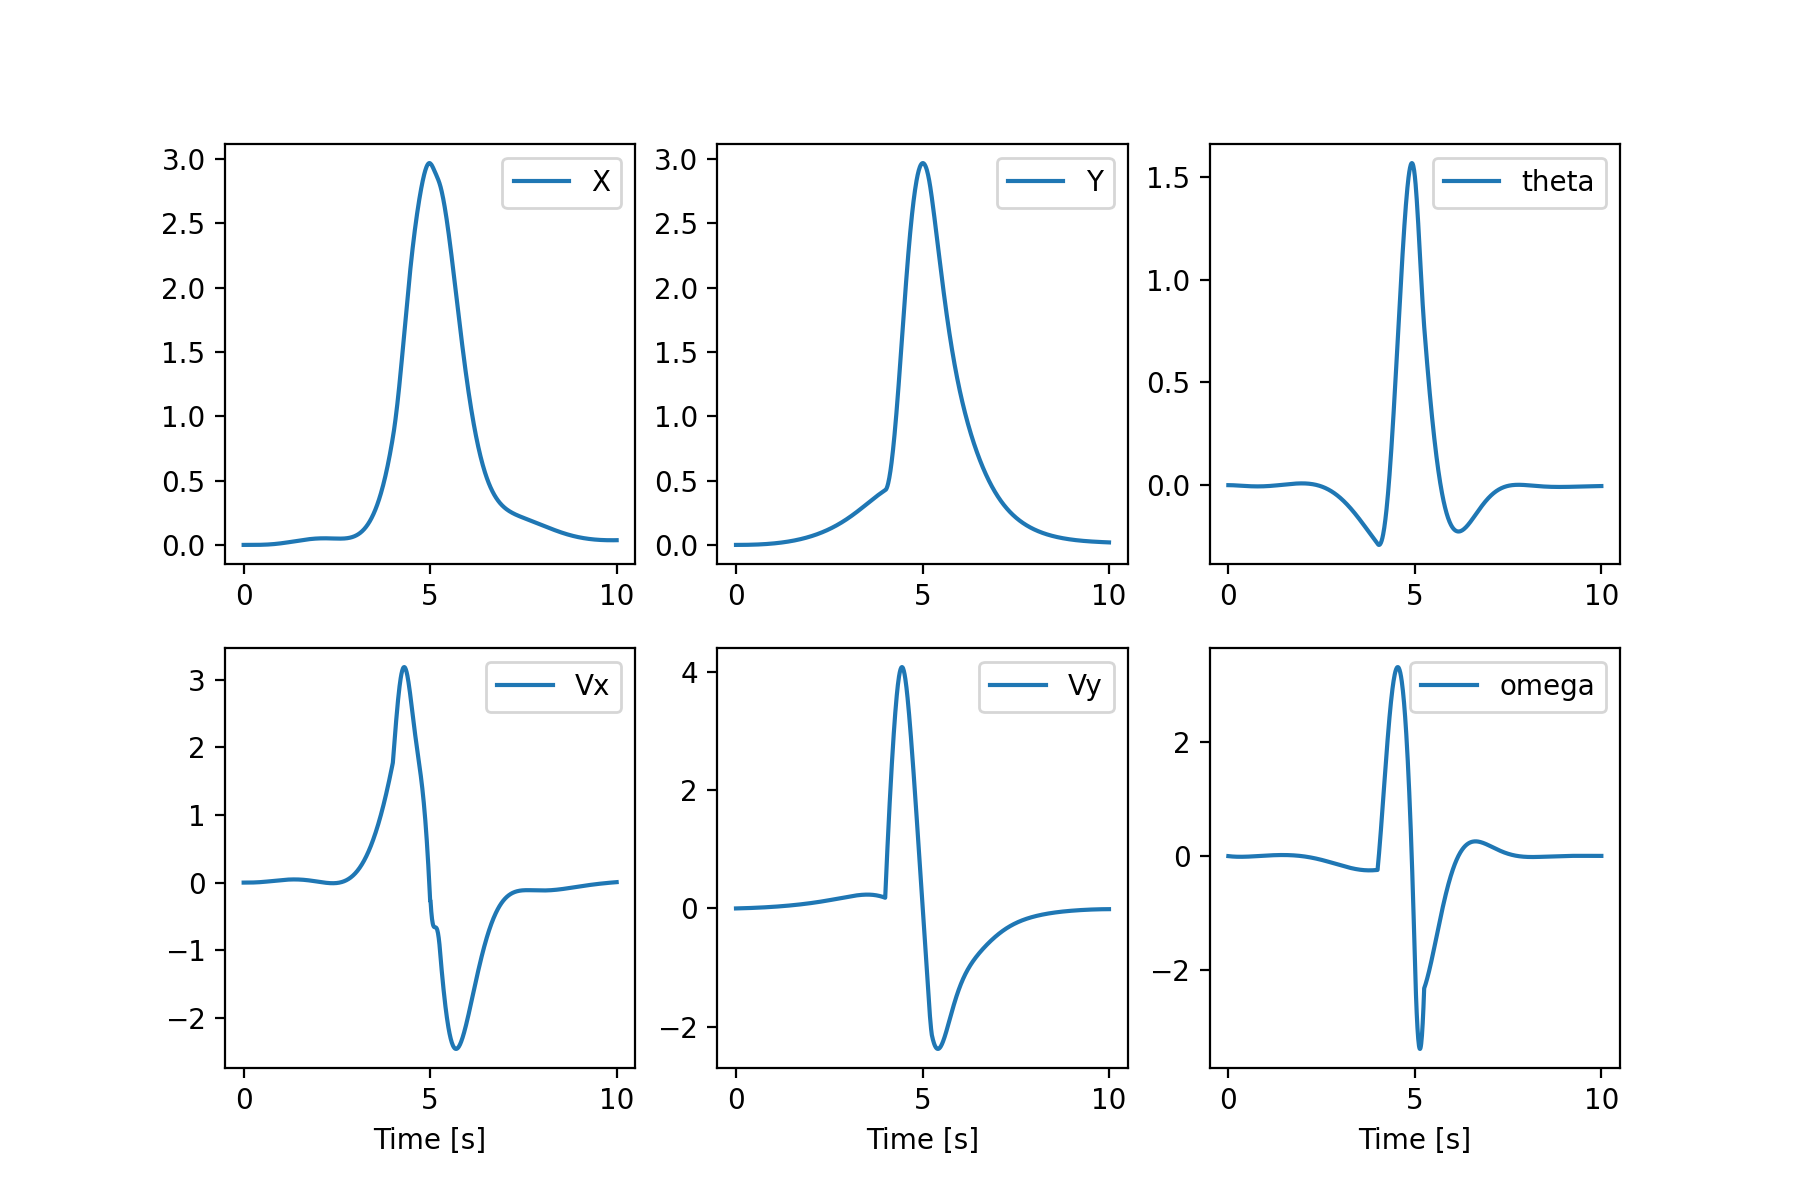

<IPython.core.display.Javascript object>


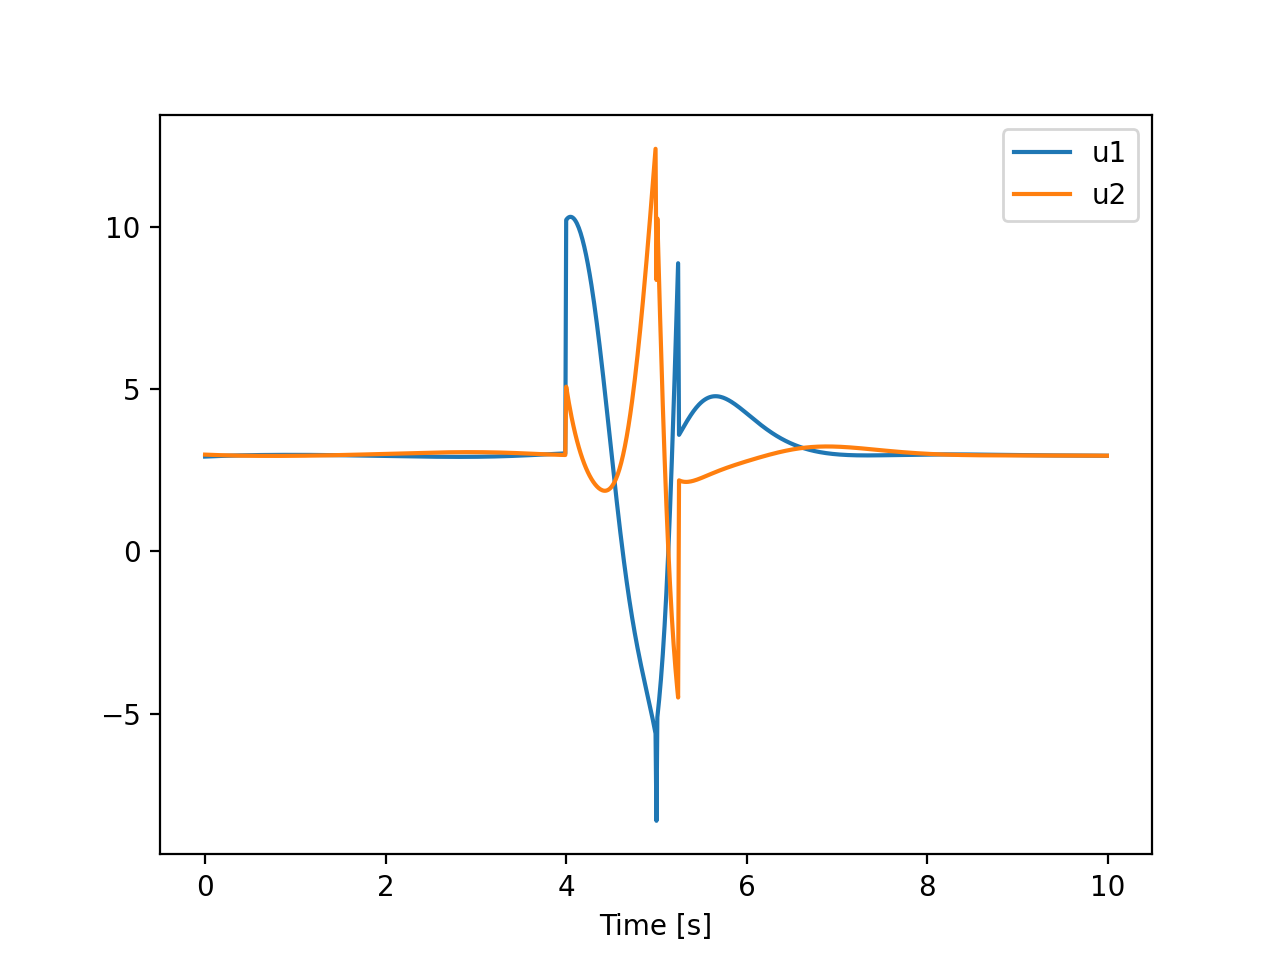

Text(0.5, 0, 'Time [s]')

In [23]:
# we can also simulate with perturbations
# t, state, u = quadrotor.simulate(z0, iLQR, horizon_length, disturbance = False)
# t, state, u = iLQR()
# print(state[:,horizon_length])

# print((state.shape)," ",(u.shape))


# # we can plot the results
plt.figure(figsize=[9,6])

plt.subplot(2,3,1)
plt.plot(t, state[0,:])
plt.legend(['X'])

plt.subplot(2,3,2)
plt.plot(t, state[2,:])
plt.legend(['Y'])

plt.subplot(2,3,3)
plt.plot(t, state[4,:])
plt.legend(["theta"])

plt.subplot(2,3,4)
plt.plot(t, state[1,:])
plt.legend(['Vx'])
plt.xlabel('Time [s]')

plt.subplot(2,3,5)
plt.plot(t, state[3,:])
plt.legend(['Vy'])
plt.xlabel('Time [s]')


plt.subplot(2,3,6)
plt.plot(t, state[5,:])
plt.legend(['omega'])
plt.xlabel('Time [s]')

# we can also plot the control
plt.figure()
plt.plot(t[:-1], u.T)
plt.legend(['u1', 'u2'])
plt.xlabel('Time [s]')



In [24]:
quadrotor.animate_robot(state,u)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAcqRtZGF0AAACsAYF//+s
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MSByMzAzME0gOGJkNmQyOCAtIEguMjY0L01Q
RUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMjAgLSBodHRwOi8vd3d3LnZpZGVvbGFu
Lm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5h
bHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhl
ZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAg
ZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0x
NSBsb29rYWhlYWRfdGhyZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGlu
dGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMg
Yl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dv
cD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFf
cmVmcmVzaD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9
MC42MCBxcG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAA
ABKcZYiEABH//veIHzLLafk613IR560urR9Q7kZxXqS9/iAAAAMAAAMAAAMACpJYniKH8XjN/AAA
AwAAt4AXsAwgCqgMKj6IdndnTzAIiR6+OnDbVkTjpPexGHLjoXY30hkXEhSE9kEKIJNbrApCI4G7
3ihHZi4T1K1iog5Wc0p6pLHThCwCmnYhSqYpYbTo2n5tZjl9Sersc3rmxTCU1aG5ejWlf2ZiBPtJ
6vuZEf6FCWPekrjf3iOxg9nYeAC3//ekaJ6Uup8pEnX74AtF5miPCXmGYp1VgIlMhblKE1f5XLlx
b1HUXmuG+fEgDCAJNggrSWMoFVS8OFpaDDMvSO64pmzh6vHDoKtfmcA4i12uUsh7rwNZe/BI7Ldb
aaCmFlaKG6p3WlZZBOgLc6Xh6KGqBk+DXTIvzmnGdaE/vYVZrpQqE5tWlH1wLzpsCVXhaMhwyKlI
HYXCzI57hN1GXk5AJs78kL3L0uFeE8COidDOFd4yzkoe/7l2h6wEKOz7uFgABdAAABgT/XL0eR8k
6J3lRIGcTlhh/LgQemvB9LeOOPbS/io9bEKpktMzUsr2rH7n7gn+AW5ayX7+OPXTsJWi5Af6cl+Q
nz0uW+DYBLS5p2thXpovCDk56tcwW0pgAmn5ff2hXXmI9LQE3pWGz9avZjnRjG4VNxvRD6MJBuoG
FZz0TZh4HejXX+Xr6AY1NtLhG5Dt0FFT7heDy2T/J56stCiLolYaEC4p05K0aorPFraz5ghGQBtP
bQZ5VBg8qxe+N9V/RoLK6+L+jsR9zqc/FKb+oyB4yMz+VqiGSA1AmSU7UJevM24L7eydq2v28GaT
OqWqMHCbTOWTxNuM9/axfRKDwC6Lso0wVC+3Ha0a7n9mpkc3W+Un55ci6TSbFMjFF3b1MWURykWb
CJ85PQh3+ppoRc3jGvBnmJGliXBKoNsDuPI5TzRngiKSJI++xRIAAAMAAAMAAAMAAAp0VA2a/arW
LxPwoBHTwZ0oXGqFZW746x5wHSckPf4eGNjDSS4E3h/9rm7GnwEJr/3+H8YrlaDOTR5xwjgOeIlw
h5Bdt6gdkU//ZrSiz8A8sRK4Ip3pzqQJmuxrBusupZOnBCCgB1GAtXRTnnmF/zozv4e91k/MQ76E
ImzqTIb21n9P9d7r4Tj4ctkcb3QLJoQ9oZLeP/mZgeDcwDgNGGa88S6KwuA1lJYLVhWkAKgpca+p
QyPAmzdqxvVmqA+n9+OAkZ+V8w3hsJXiyDlJzJQRftHHD/UZKmOov2gOVYG65nsP/pBy7ZThxPON
jqtapHzZ1I6Z/ntfJQnRK/UMqZA7MWBpwF2yAbQ8OXRgICKj/J+zwq9DQs5aprG52N8+wdyZw6Op
Knot6APk5kCQAAbt3cswf98VQgESJkJJAA+SWSIQAb8pg7QEFCLe6x9Zzxyi5C24b05PSE+hR+Eg
gohmIxcZh0elgKDRY8mlCqHcbxEm594ROE2dJzfl2Dqpd2M+MS5ruFrOWGZNN1bVHlmfbBTpfHg9
W2UxJ+a2R3nDDaIZZIrxwAE1nU8Nw6JRlC4/4Zod+2K6jCJjbBlLYpkFsk3og8YD4K250VTSb3dT
SzhD9I2ZBnmcm00cowt9f/YLxyZtDPHk7Hplbz09W3c+Wzd8AyXyAfK/ZSRHtc8hqRajX5giHsLK
evZSXOYXdpOzWaMmTFJ3AaJkGj6/dodcx2nao8FRdfe27LH3IMby3xZwLnHGnwfbRog6xjQwXCu8
rQNxGRx9dKQ5epjb8f3bT9qeHCvQFW/yoepy+ZFgfMHra/m/r/JCMWGesdYqDFb4linLAoBmVMVe
J938Xv+O6AhFeZwSttRhOkl6NWO0QY6Q3aKC0xc66DVHttxVPAzhk2YqJRJTs0QgS3trEyeB5X6r
MjeZPwAAWOLocqbF9UAAB4RuDobJLzgAcsbWOPifWsyHyd9OXJNCnXl9avNI4+bJyP7Z/3fasyJx
4gf4APpVPZtB9qZ+k1IAlVJ9fQecsqj1PMwwMafto/ENJYKpA7qK8qkxJzIXsHBTp2Lm4xCpBeRQ
Bt0YPC+FKx14aenRwIdYkjyDiszGVgxKi1nxCcgUaKgrcfy5Iaeq47kcfT9/ddt4oKVEEI8goFOU
VaDRWab+SXaGQCNBbF8Uc6Tro+hAwEoA/RHdchG5DAGAdlefx9LU4GoLxADH0Bj1BKZmI0H7UrCu
pRGDRqao/5ZLzdnblnHCK/LtTS09Z0qKM9oujsrSCBUk08klO+FioMIxgBmAwU00ulM0Koaib+c5
o9ieLxNpszSnTFirXQCD380VYhH8NkmB7zmjVdRmv6aQY+1CRBkUmZMbRmgoYV24i62WE6dYfSyX
g+nQwkGAcO6R++GkoHbkbJEokNRH3o/+7kyS53NsLhW1eaclmghRMrAyR4PrY+qNe6Wm5Sdp0P1S
P7tqPQ7NvxqDSQPn9v65bqeON5+nhDg72MIOu72zFuCDnigzXvcxKuvGxTSeu5t5GTshyb8QVJsC
hhhrFBZJrnFsHgQg74WHriy5NFZ9x2eg32/C/R/JaonbHxjVbMHwfQVbNQdWvQsq0O+H0hoDej4i
QyX7bsO+lYr2b5xEEPU+jXJ9kfvltyTTN5ejtY+fbcmYjsVOiP80EEdZ0KPMSRH4OAc+g6TyvMlv
8vYnwRczQUhxflg1QtLTfKgKJW4m82Kd89pPCn77QFD3xgfy4UnFIDSoM2JDlMWRcJfeBDZIbUjj
Bz0WTr8iJ3bEP4hKbRkhjI/V9ekmmnLEMLOc//yW//VGw87g9tO4L/4XjH3Jb6YbK1YAMbDRvVCM
krRZ9XbPMY8iveCfMQo0mtL1YeSW6o2fBkeDfRxRItU8Uu+2mvk5mCAEucS8Tf+OKHzZZkzxjhY/
DL9cAAADAiJAWeXdgd+kJ

# Part 4.2

In [25]:
def get_coeff(n):
    dt = quadrotor.DELTA_T
    t = dt*n
    u_static = quadrotor.MASS*quadrotor.GRAVITY/2
    u_star = np.array([u_static,u_static])
    z_star = None
    r = np.zeros((2,1))
    q = np.zeros((6,1))
    if t<4.0:
        Q = 10*np.eye(6)
        R = 100*np.eye(2)
    elif t< 4.99:
        Q = 1*np.eye(6)
        R = 1*np.eye(2)
    elif t == 5.0:
        Q = 2000*np.array([[50,0,0,0,0,0],[0,0,0,0,0,0],[0,0,50,0,0,0],
                            [0,0,0,0,0,0],[0,0,0,0,50,0],[0,0,0,0,0,0]])
        R = 1*np.eye(2)
        z_star = np.array([1.5,0,3,0,np.pi,0])
        u_star = None
        q = -np.matmul(Q,np.reshape(z_star,(6,1)))
    elif t< 5.25:
        Q = 10*np.eye(6)
        R = 1*np.eye(2)
        z_star = np.array([3,0,0,0,2*np.pi,0])
        q = -np.matmul(Q,np.reshape(z_star,(6,1)))
        u_star = None
    elif t == 5.25:
        Q = 10*np.eye(6)
        Q[4,4] = 100000
        R = 1*np.eye(2)
        z_star = np.array([3,0,0,0,2*np.pi,0])
        q = -np.matmul(Q,np.reshape(z_star,(6,1)))
        u_star = None
    elif t< 9.75:
        Q = 10*np.eye(6)
        Q[4,4] = 2000
        R = 10*np.eye(2)
        z_star = np.array([3,0,0,0,2*np.pi,0])
        q = -np.matmul(Q,np.reshape(z_star,(6,1)))

    elif t< 10.0:
        Q = np.eye(6)
        R = np.eye(2)
        z_star = np.array([3,0,0,0,2*np.pi,0])
        q = -np.matmul(Q,np.reshape(z_star,(6,1)))
    elif t == 10.0:
        Q = 2000*np.array([[50,0,0,0,0,0],[0,0,0,0,0,0],[0,0,50,0,0,0],
                            [0,0,0,0,0,0],[0,0,0,0,50,0],[0,0,0,0,0,0]])
        R = 500*np.eye(2)
        z_star = np.array([3,0,0,0,2*np.pi,0])
        q = -np.matmul(Q,np.reshape(z_star,(6,1)))

#     print(n)
    if u_star is not None:
        r = -np.matmul(R,np.reshape(u_star,(2,1)))
    
    return Q, R, q, r

In [26]:
def iLQR_flip(state,i):
    if i == 0:
        horizon = 1001
        arb_u = np.ones((2,horizon-1))*quadrotor.MASS*quadrotor.GRAVITY/2
        solve_LQR_trajectory(arb_u,horizon)

    return solve_LQR_trajectory.u[:,i]

In [27]:
horizon_length = 1000
z0 = np.zeros([quadrotor.NUMBER_STATES,])
t, state, u = quadrotor.simulate(z0, iLQR_flip, horizon_length, disturbance = False)

[[-2316776.62510285]]
[[-5434706.86191514]]
[[-9601889.59498463]]
[[-11575003.23241401]]
[[-13206033.48520151]]
[[-15944281.13535152]]
[[-17683537.74874115]]
[[-18800172.3426986]]
[[-19489911.35134761]]
[[-20288017.63117556]]
[[-20712986.54348255]]
[[-20957047.0672534]]
[[-21059777.71038949]]
[[-21100575.46883507]]
[[-21120030.10797318]]
[[-21121749.09580414]]
[[-21121751.45127821]]
17
[[-21121751.45126915]]
18
[[-21121751.45125997]]
19
[[-21121751.45125071]]
20
[[-21121751.45124139]]
21
[[-21121751.45123196]]
22
[[-21121751.45122251]]
23
[[-21121751.45121299]]
24
[[-21121751.45120338]]
25
[[-21121751.45119378]]
26
[[-21121751.45118412]]
27
[[-21121751.45117446]]
28
[[-21121751.45116475]]
29
[[-21121751.45115503]]
30
[[-21121751.45114526]]
31
[[-21121751.45113553]]
32
[[-21121751.45112578]]
33
[[-21121751.45111605]]
34
[[-21121751.45110634]]
35
[[-21121751.45109658]]
36
[[-21121751.45108687]]
37
[[-21121751.45107719]]
38
[[-21121751.45106752]]
39
[[-21121751.45105789]]
40
[[-21121751.4

(6, 1001)   (2, 1000)


<IPython.core.display.Javascript object>


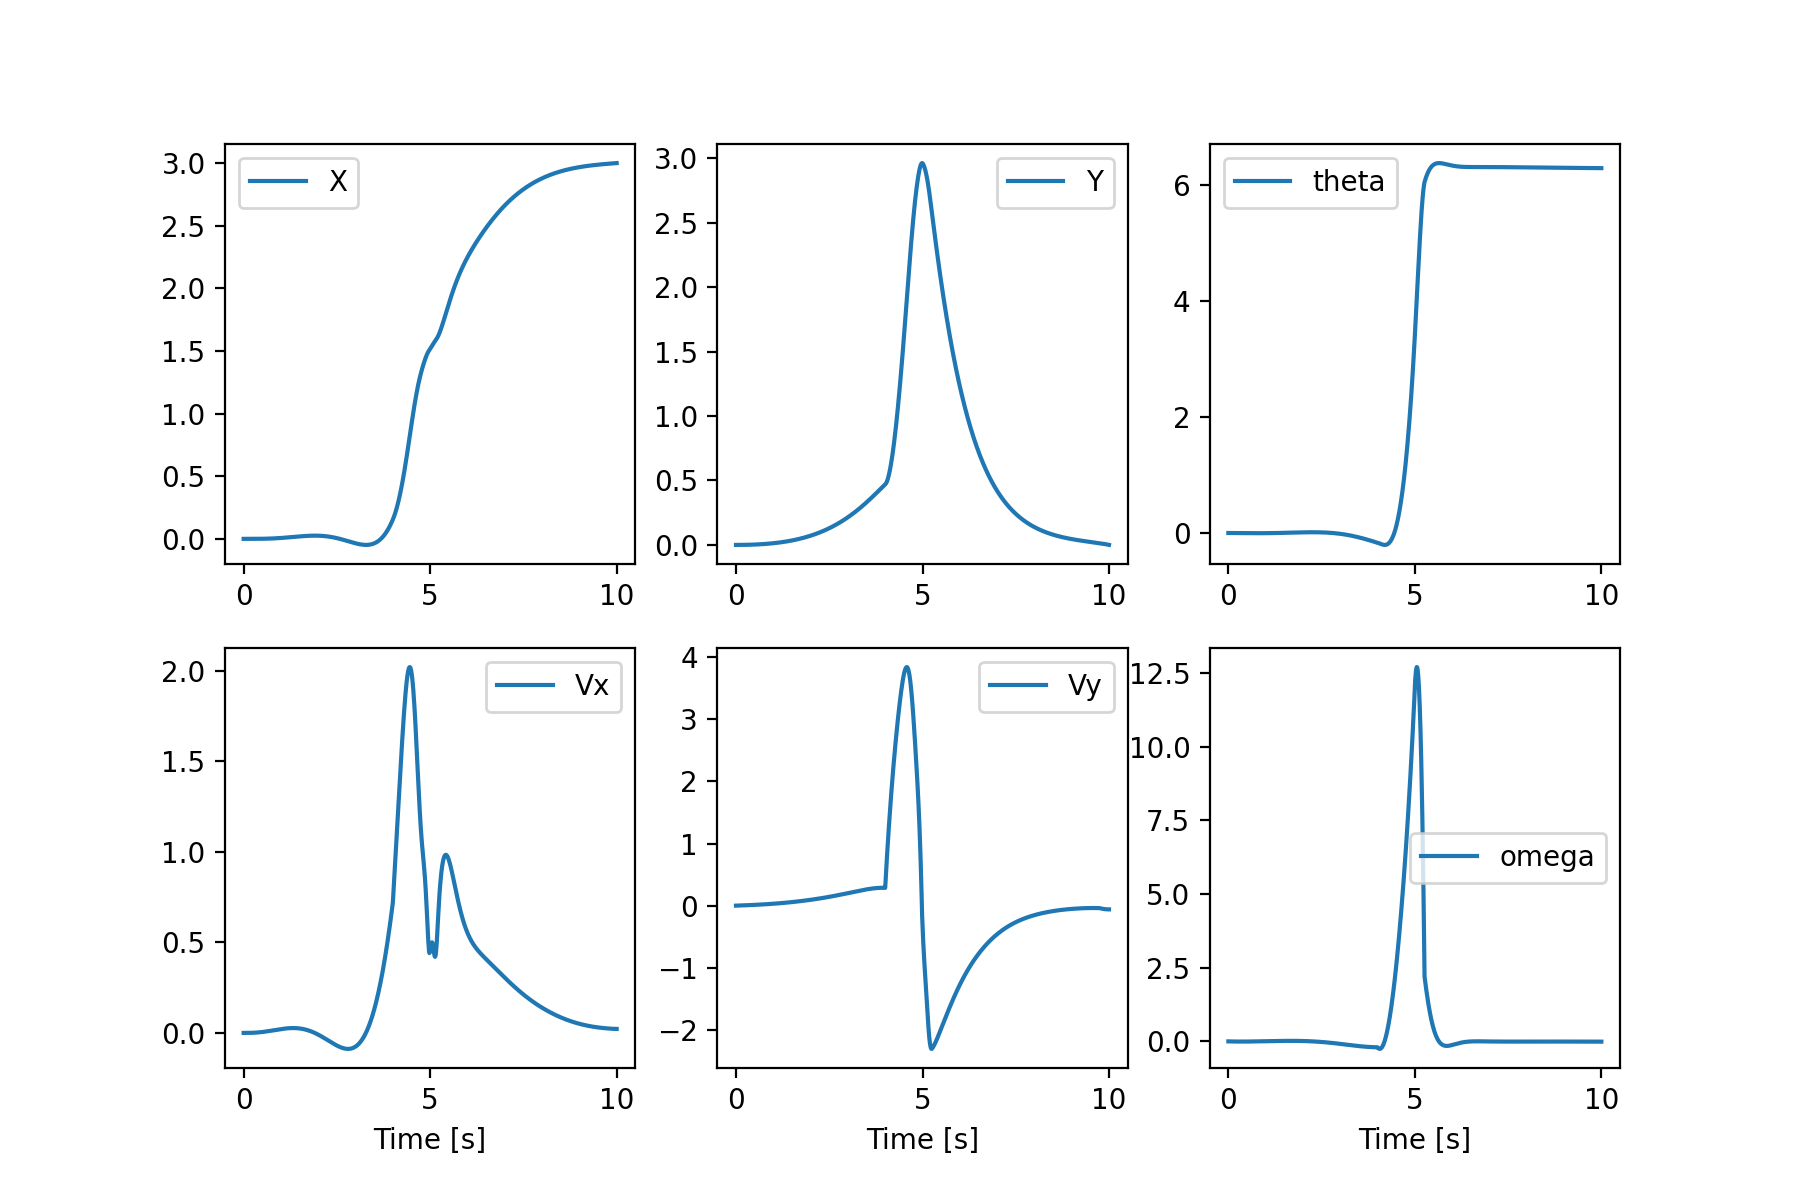

<IPython.core.display.Javascript object>


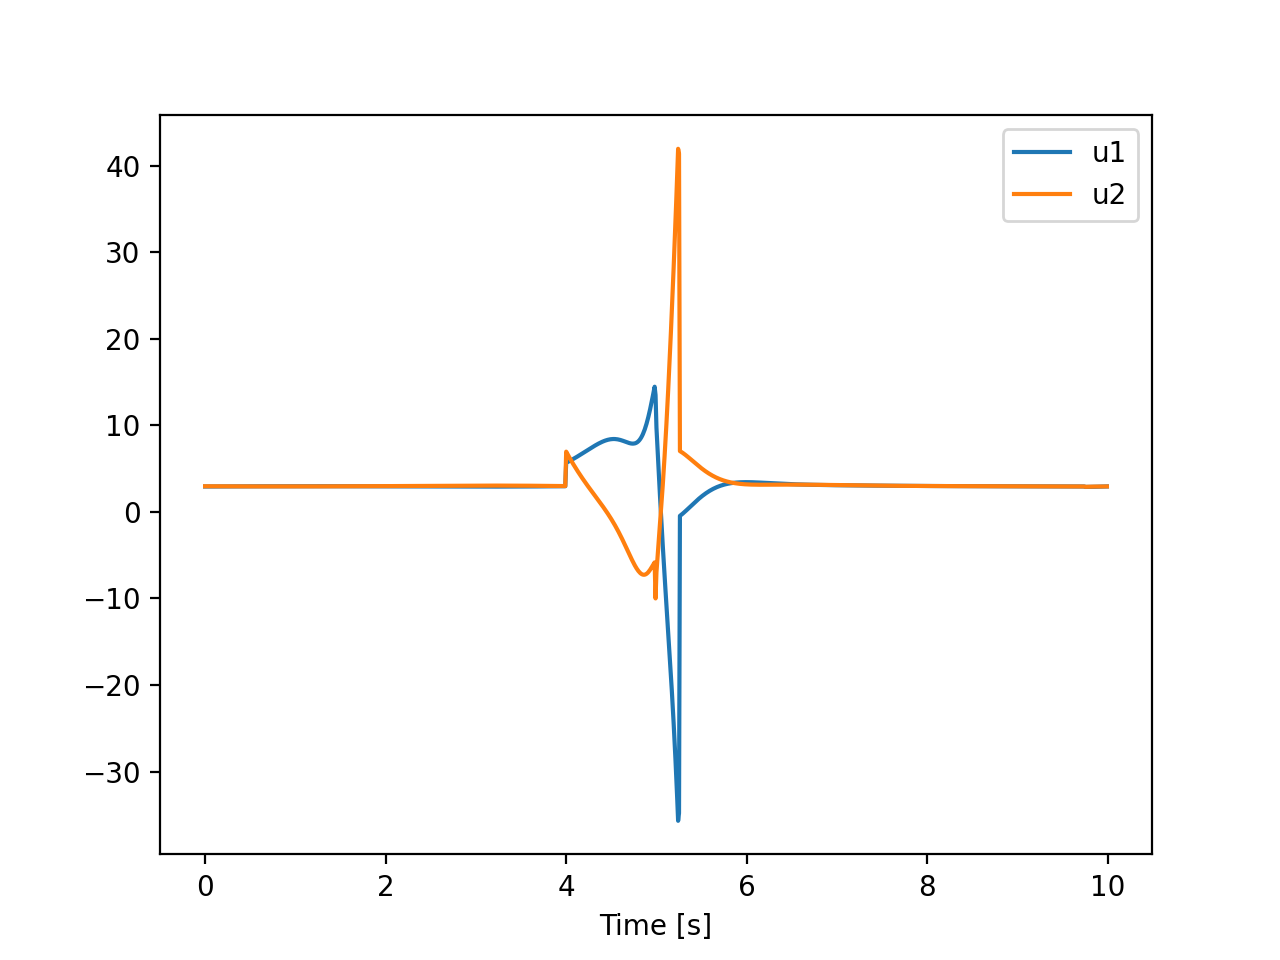

Text(0.5, 0, 'Time [s]')

In [28]:
# we can also simulate with perturbations
# t, state, u = quadrotor.simulate(z0, iLQR, horizon_length, disturbance = False)
# t, state, u = iLQR_flip()
# print(state[:,horizon_length])

print((state.shape)," ",(u.shape))


# # we can plot the results
plt.figure(figsize=[9,6])

plt.subplot(2,3,1)
plt.plot(t, state[0,:])
plt.legend(['X'])

plt.subplot(2,3,2)
plt.plot(t, state[2,:])
plt.legend(['Y'])

plt.subplot(2,3,3)
plt.plot(t, state[4,:])
plt.legend(["theta"])

plt.subplot(2,3,4)
plt.plot(t, state[1,:])
plt.legend(['Vx'])
plt.xlabel('Time [s]')

plt.subplot(2,3,5)
plt.plot(t, state[3,:])
plt.legend(['Vy'])
plt.xlabel('Time [s]')


plt.subplot(2,3,6)
plt.plot(t, state[5,:])
plt.legend(['omega'])
plt.xlabel('Time [s]')

# we can also plot the control
plt.figure()
plt.plot(t[:-1], u.T)
plt.legend(['u1', 'u2'])
plt.xlabel('Time [s]')




In [29]:
quadrotor.animate_robot(state,u)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAcRltZGF0AAACsAYF//+s
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MSByMzAzME0gOGJkNmQyOCAtIEguMjY0L01Q
RUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMjAgLSBodHRwOi8vd3d3LnZpZGVvbGFu
Lm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5h
bHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhl
ZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAg
ZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0x
NSBsb29rYWhlYWRfdGhyZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGlu
dGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMg
Yl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dv
cD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFf
cmVmcmVzaD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9
MC42MCBxcG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAA
ABLbZYiEABH//veIHzLLafk613IR560urR9Q7kZxXqS9/iAAAAMAAAMAAAMACpJYniKH8XjN/AAA
AwAAt4AXsAwgCqgMKj6IdndnTzAIiR6+OnDbVkTjpPexGHLjoXY30hkXEhSE9kEKIJNbrApCI4G7
3ihHZi4T1K1iog5Wc0p6pLHThCwCmnYhSqYpYbTo2n5tZjl9Sersc3rmxTCU1aG5ejWlf2ZiBPtJ
6vuZEf6FCWPekrjf3iOxg9nYeAC3//ekaJ6Uup8pEnX74AtF5miPCXmGYp1VgIlMhblKE1f5XLlx
b1HUXmuG+fEgDCAJNggrSWMoFVS8OFpaDDMvSO64pmzh6vHDoKtfmcA4i12uUsh7rwNZe/BI7Ldb
aaCmFlaKG6p3WlZZBOgLc6Xh6KGqBk+DXTIvzmnGdaE/vYVZrpQqE5tWlH1wLzpsCVXhaMhwyKlI
HYXCzI57hN1GXk5AJs78kL3L0uFeE8COidDOFd4yzkoe/7l2h6wEKOz7uFgABdAAABgT/XL0eR8k
6J3lRIGcTlhh/LgQemvB9LeOOPbS/io9bEKpktMzUsr2rH7n7gn+AW5ayX7+OPXTsJWi5Af6cl+Q
nz0uW+DYBLS5p2thXpovCDk56tcwW0pgAmn5ff2hXXmI9LQE3pWGz9avZjnRjG4VNxvRD6MJBuoG
FZz0TZh4HejXX+Xr6AY1NtLhG5Dt0FFT7heDy2T/J56stCiLolYaEC4p05K0aorPFraz5ghGQBtP
bQZ5VBg8qxe+N9V/RoLK6+L+jsR9zqc/FKb+oyB4yMz+VqiGSA1AmSU7UJevM24L7eydq2v28GaT
OqWqMHCbTOWTxNuM9/axfRKDwC6Lso0wVC+3Ha0a7n9mpkc3W+Un55ci6TSbFMjFF3b1MWURykWb
CJ85PQh3+ppoRc3jGvBnmJGliXBKoNsDuPI5TzRngiKSJI++xRIAAAMAAAMAAAMAAAp0VA2a/arW
LxPwoBHTwZ0oXGqFZW746x5wHSckPf4eGNjDSS4E3h/9rm7GnwEJr/3+H8YrlaDOTR5xwjgOeIlw
h5Bdt6gdkU//ZrSiz8A8sRK4Ip3pzqQJmuxrBusupZOnBCCgB1GAtXRTnnmF/zozv4e91k/MQ76E
ImzqTIb21n9P9d7r4Tj4ctkcb3QLJoQ9oZLeP/mZgeDcwDgNGGa88S6KwuA1lJYLVhWkAKgpca+p
QyPAmzdqxvVmqA+n9+OAkZ+V8w3hsJXiyDlJzJQRftHHD/UZKmOov2gOVYG65nsP/pBy7ZThxPON
jqtapHzZ1I6Z/ntfJQnRK/UMqZA7MWBpwF2yAbQ8OXRgICKj/J+zwq9DQs5aprG52N8+wdyZw6Op
Knot6APk5kCQAAbt3cswf98VQgESJkJJAA+SWSIQAb8pg7QEFCLe6x9Zzxyi5C24b05PSE+hR+Eg
gohmIxcZh0elgKDRY8mlCqHcbxEm594ROE2dJzfl2Dqpd2M+MS5ruFrOWGZNN1bVHlmfbBTpfHg9
W2UxJ+a2R3nDDaIZZIrxwAE1nU8Nw6JRlC4/4Zod+2K6jCJjbBlLYpkFsk3og8YD4K250VTSb3dT
SzhD9I2ZBnmcm00cowt9f/YLxyZtDPHk7Hplbz09W3c+Wzd8AyXyAfK/ZSRHtc8hqRajX5giHsLK
evZSXOYXdpOzWaMmTFJ3AaJkGj6/dodcx2nao8FRdfe27LH3IMby3xZwLnHGnwfbRog6xjQwXCu8
rQNxGRx9dKQ5epjb8f3bT9qeHCvQFW/yoepy+ZFgfMHra/m/r/JCMWGesdYqDFb4linLAoBmVMVe
J938Xv+O6AhFeZwSttRhOkl6NWO0QY6Q3aKC0xc66DVHttxVC/vpUkUL742i9qBgzZjQ5G6W36rg
/ekHAAAdY5/I7V+fIAACSt9w1AmbTQAsVfJahCvn1yHyd9Nm1sS7krrlaFvB56fWgpJBVfz9pi8o
hOIKo4A7yKUOrrA+wtejNk4JVaZF++qnXD9WWhAIkilHiqX1x7u8jzhC9tJGqVZ7UPSMXYI1X1rN
sAmvYj7IkmONkH0feQIe6j4B1CwMY2mi6tbo7jCJHtVJ3rPSycNjbj0ObB7BlPrvJ/RbDNgpYCiE
3ns8VzqsAqYn7DYN3pu24NJ10fQgYj8Npumtnn6zT3WUZNnv8FASnV5X+AI79EWxAcYkI0H7UrCu
pRGDlqao/5ZL5FfB9sIithaMVSnazpUUcsRwFJGekCNtMdJKecDVN8yat78BgpppdI4ZKtMiPomz
iA67GevM+QBU0fn8wXHT1EfJ+JdYqE1WFsjQY+1CRBkXUm4hRmgoYXj8dnXA6R78kVTcSpDFjpSz
Re6R++CkNu2ihgrxgVxH/X7uLoJuxehEGO5o9+wZcRDqZWBkjwfXHj1vXbFYzRYfFjGfbtDGmrfQ
UHuc9L6Ahp9pxMoAUSlpN6oLZnVsD/s8MW4I7zfwbH/vDYkoSiQ88Rv9SQ1/8HRCh/L+x6Ud7YLe
le9foF3EV0tf0qmgfxf55MscLCAVUc+/JMBkVxKxnDi138ohDKEAUjyVYg5l5fNcbSA9auDNzX7R
wHW2O2J1Z9yfuXdAccbCtQScZhB4pJMtaRF1fLL45e3hmugW5aPrS2xV8dqKygB2B0O9SsJqe6/p
60wcGf0yUOGgYabZ68NY/MumE6nAbF54iyaR/stGtPBlpNEQONFQfjY0qmJTuZLUJRFVq+FD0SF/
gNghzsJws14Y4HH1+RE7sRMawNsO6Qxkfq+vRzITliOtNd8j78n/t9kke7RYjlqP8M8UJVv/IBla
ugt0Qktotve6nw+rtq8CD224gnzEKNJrMs2XZ9j6/x5nDnRCaQl46ozqgdbTmWnbzguL0ZzVhk3/
hUFRyE3G88xOe+WhcToBq